# Multi-Objective Fairness Analysis

This notebook implements multi-objective hyperparameter optimization for fairness-aware machine learning, exploring the trade-off between **accuracy** and **counterfactual consistency** (individual fairness).

## Overview

**Two Approaches:**
1. **Approach 1**: Models trained WITH sensitive features — evaluate counterfactual consistency by flipping sensitive attributes directly
2. **Approach 2**: Models trained WITHOUT sensitive features — evaluate consistency using proxy features

**Models:** Random Forest, MLP, SenSeI (optional)

**Sensitive Features Analyzed:** Sex (binary), Race (multiclass)

## 0. Setup & Configuration

This section initializes the notebook environment, imports required modules, and defines configuration variables and helper functions used throughout the analysis.

### 0.1 Imports & Module Reload

In [61]:
# ============================================================================
# 0.1 IMPORTS & MODULE RELOAD
# ============================================================================

# Add src to path
import sys
sys.path.insert(0, '../src')

import warnings
warnings.filterwarnings('ignore')

# For development: reload modules to pick up changes
import importlib
datasets = importlib.import_module("utils.datasets")
importlib.reload(datasets)
plotting = importlib.import_module("utils.plotting")
importlib.reload(plotting)
main = importlib.import_module("main")
importlib.reload(main)

# --- Core Imports ---
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Any
from IPython.display import Image, display
from sklearn.model_selection import train_test_split  

# --- Project Imports ---
from main import (
    run_optimization,
    get_dataset_config,
    get_configspace,
    list_available_datasets,
    get_pareto_front,
    print_pareto_summary,
    create_rf_model,
    create_mlp_model,
)

from utils.plotting import (
    plot_pareto_comparison,
    plot_parallel_coordinates,
    plot_mds_projection,
    generate_all_visualizations,
    compute_fairness_confusion_matrix,
    plot_fairness_confusion_matrix,
    print_fairness_confusion_summary,
)

from utils.datasets import load_dataset, create_flipped_data

print("✅ All modules imported successfully!")
print(f"Available datasets: {list_available_datasets()}")

✅ All modules imported successfully!
Available datasets: ['adult', 'german_credit', 'compas']


### 0.2 Configuration

Global configuration variables for the analysis. Modify these to change:
- Dataset and output paths
- Data split ratios
- SMAC optimization settings
- Caching behavior

In [62]:
# ============================================================================
# 0.2 CONFIGURATION
# ============================================================================

# Dataset
DATASET_NAME = "adult"

# Output directories
OUTPUT_DIR = "../plots"
CACHE_DIR = "../cache"

# Data split settings
TEST_SIZE = 0.2   # 20% for final evaluation
VAL_SIZE = 0.25   # 25% of remaining = 20% of total for validation
RANDOM_STATE = 42

# SMAC settings
WALLTIME_LIMIT = 300  # seconds per model
N_TRIALS = 100        # max configurations per model

# Caching
LOAD_FROM_CACHE = True  # Set to False to re-run optimization

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/notebook", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/latex", exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

print("✅ Configuration loaded!")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Load from cache: {LOAD_FROM_CACHE}")

✅ Configuration loaded!
   Dataset: adult
   Load from cache: True


### 0.3 Caching Utilities

Caching mechanism for SMAC optimization results. This allows re-running analysis without repeating time-consuming optimization:

- **`LOAD_FROM_CACHE = True`**: Load previously saved results
- **`LOAD_FROM_CACHE = False`**: Run fresh optimization and save results

Cached results are stored in the `cache/` directory as pickle files.

In [63]:
# ============================================================================
# 0.3 CACHING UTILITIES
# ============================================================================

@dataclass
class CachedConfig:
    """Simple wrapper to mimic ConfigSpace Configuration."""
    values: Dict[str, Any]
    
    def __getitem__(self, key):
        return self.values[key]
    
    def keys(self):
        return self.values.keys()
    
    def __iter__(self):
        return iter(self.values)
    
    def items(self):
        return self.values.items()


class CachedRunHistory:
    """Mock runhistory that provides the same interface as SMAC's runhistory."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self._configs = [CachedConfig(c) for c in configs]
        self._costs = {i: cost for i, cost in enumerate(costs)}
    
    def get_configs(self):
        return self._configs
    
    def average_cost(self, config):
        idx = self._configs.index(config)
        return self._costs[idx]


class CachedSMAC:
    """Mock SMAC facade that provides the same interface for visualization."""
    
    def __init__(self, configs: List[Dict], costs: List[tuple]):
        self.runhistory = CachedRunHistory(configs, costs)


def save_smac_results(results: Dict, dataset_name: str, sensitive_feature: str, approach: int = 1):
    """Save SMAC results to cache."""
    cache_data = {}
    
    for model_type, smac in results.items():
        configs = smac.runhistory.get_configs()
        configs_as_dicts = [dict(c) for c in configs]
        costs = [smac.runhistory.average_cost(c) for c in configs]
        
        cache_data[model_type] = {
            'configs': configs_as_dicts,
            'costs': costs,
        }
    
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"✅ Results cached to: {cache_file}")
    return cache_file


def load_smac_results(dataset_name: str, sensitive_feature: str, approach: int = 1) -> Dict:
    """Load SMAC results from cache."""
    cache_file = f"{CACHE_DIR}/smac_results_{dataset_name}_{sensitive_feature}_approach{approach}.pkl"
    
    if not os.path.exists(cache_file):
        raise FileNotFoundError(f"Cache file not found: {cache_file}\nRun optimization first with LOAD_FROM_CACHE=False")
    
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
    
    results = {}
    for model_type, data in cache_data.items():
        results[model_type] = CachedSMAC(data['configs'], data['costs'])
    
    print(f"✅ Results loaded from cache: {cache_file}")
    return results


print("✅ Caching utilities loaded!")

✅ Caching utilities loaded!


### 0.4 Helper Functions

Reusable functions for data processing, analysis, and visualization. These are used across both Approach 1 and Approach 2 sections.

In [70]:
# ============================================================================
# 0.4 HELPER FUNCTIONS
# ============================================================================

def split_data(data, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    """Split data into train/validation/test sets."""
    X_full = data['X_train'].copy()
    y_full = data['y_train'].copy()
    
    # Split off test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_full, y_full, test_size=test_size, random_state=random_state, stratify=y_full
    )
    
    # Split remaining into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )
    
    # Update data dict
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_val'] = X_val
    data['y_val'] = y_val
    data['X_test'] = X_test
    data['y_test'] = y_test
    
    print(f"Data split: Train={len(X_train):,}, Val={len(X_val):,}, Test={len(X_test):,}")
    return data


def plot_sensitive_distribution(data, dataset_name, sensitive_feature):
    """
    Plot the distribution of sensitive feature(s) vs target variable with disparity analysis.
    
    Parameters:
    -----------
    data : dict
        Data dictionary containing X_train, y_train, and sensitive feature info
    dataset_name : str
        Name of the dataset (e.g., 'adult')
    sensitive_feature : str
        Name of the sensitive feature (e.g., 'sex', 'race')
    """
    X_train = data['X_train']
    y_train = data['y_train']
    
    # Determine if binary or multiclass based on which keys exist
    is_multiclass = 'sensitive_col_indices' in data
    
    # Get target label names (customize based on dataset)
    target_names = {0: 'Income ≤50K', 1: 'Income >50K'} if dataset_name == 'adult' else {0: 'Class 0', 1: 'Class 1'}
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if is_multiclass:
        # Multiclass sensitive feature (e.g., race)
        sens_indices = data['sensitive_col_indices']
        sens_names = data.get('sensitive_col_names', [f'Cat_{i}' for i in range(len(sens_indices))])
        n_categories = len(sens_names)
        
        # Determine which category each sample belongs to
        categories = np.argmax(X_train[:, sens_indices], axis=1)
        
        # Count samples per category and target
        category_target_counts = {}
        for cat_idx, cat_name in enumerate(sens_names):
            mask = (categories == cat_idx)
            pos_count = (y_train[mask] == 1).sum()
            neg_count = (y_train[mask] == 0).sum()
            category_target_counts[cat_name] = {'positive': pos_count, 'negative': neg_count, 'total': mask.sum()}
        
        # Plot 1: Stacked bar chart (absolute counts)
        cat_names = list(category_target_counts.keys())
        pos_counts = [category_target_counts[c]['positive'] for c in cat_names]
        neg_counts = [category_target_counts[c]['negative'] for c in cat_names]
        
        x = np.arange(len(cat_names))
        width = 0.6
        
        bars1 = axes[0].bar(x, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
        bars2 = axes[0].bar(x, pos_counts, width, bottom=neg_counts, label=target_names[1], color='#e74c3c', alpha=0.8)
        
        axes[0].set_xlabel(f'Sensitive Feature: {sensitive_feature.title()}', fontsize=11)
        axes[0].set_ylabel('Count', fontsize=11)
        axes[0].set_title('Distribution by Sensitive Group (Absolute)', fontsize=12, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(cat_names, rotation=45, ha='right')
        axes[0].legend()
        
        # Add count labels
        for i, (neg, pos) in enumerate(zip(neg_counts, pos_counts)):
            axes[0].annotate(f'{neg+pos:,}', (i, neg+pos+50), ha='center', fontsize=9)
        
        # Plot 2: Base rate (percentage positive) per group
        base_rates = [100 * category_target_counts[c]['positive'] / category_target_counts[c]['total'] 
                      for c in cat_names]
        
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(cat_names)))
        bars = axes[1].bar(x, base_rates, width, color=colors, edgecolor='black', linewidth=0.5)
        
        axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                        label=f'Overall rate: {100*y_train.mean():.1f}%')
        axes[1].set_xlabel(f'Sensitive Feature: {sensitive_feature.title()}', fontsize=11)
        axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
        axes[1].set_title('Base Rate Disparity (% Positive Outcome)', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(cat_names, rotation=45, ha='right')
        axes[1].legend()
        axes[1].set_ylim(0, max(base_rates) * 1.2)
        
        # Add percentage labels
        for i, rate in enumerate(base_rates):
            axes[1].annotate(f'{rate:.1f}%', (i, rate + 1), ha='center', fontsize=10, fontweight='bold')
        
        # For summary
        grp_names = cat_names
        counts = category_target_counts
        sens_name = sensitive_feature

    else:
        # Binary sensitive feature (e.g., sex)
        sens_idx = data['sensitive_col_idx']
        sens_name = data.get('sensitive_col_name', sensitive_feature)
        
        # Get group labels (customize based on feature)
        if 'sex' in sensitive_feature.lower():
            group_names = {0: 'Female', 1: 'Male'}
        else:
            group_names = {0: f'{sens_name}=0', 1: f'{sens_name}=1'}
        
        # Count samples per group and target
        group0_mask = (X_train[:, sens_idx] == 0)
        group1_mask = (X_train[:, sens_idx] == 1)
        
        counts = {
            group_names[0]: {'positive': int((y_train[group0_mask] == 1).sum()), 
                             'negative': int((y_train[group0_mask] == 0).sum()),
                             'total': int(group0_mask.sum())},
            group_names[1]: {'positive': int((y_train[group1_mask] == 1).sum()), 
                             'negative': int((y_train[group1_mask] == 0).sum()),
                             'total': int(group1_mask.sum())}
        }
        
        # Plot 1: Grouped bar chart
        grp_names = list(counts.keys())
        x = np.arange(len(grp_names))
        width = 0.35
        
        neg_counts = [counts[g]['negative'] for g in grp_names]
        pos_counts = [counts[g]['positive'] for g in grp_names]
        
        bars1 = axes[0].bar(x - width/2, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
        bars2 = axes[0].bar(x + width/2, pos_counts, width, label=target_names[1], color='#e74c3c', alpha=0.8)
        
        axes[0].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
        axes[0].set_ylabel('Count', fontsize=11)
        axes[0].set_title('Distribution by Sensitive Group', fontsize=12, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(grp_names)
        axes[0].legend()
        
        # Add count labels
        for bar in bars1:
            axes[0].annotate(f'{int(bar.get_height()):,}', 
                             (bar.get_x() + bar.get_width()/2, bar.get_height()),
                             ha='center', va='bottom', fontsize=9)
        for bar in bars2:
            axes[0].annotate(f'{int(bar.get_height()):,}', 
                             (bar.get_x() + bar.get_width()/2, bar.get_height()),
                             ha='center', va='bottom', fontsize=9)
        
        # Plot 2: Base rate comparison
        base_rates = [100 * counts[g]['positive'] / counts[g]['total'] for g in grp_names]
        
        colors = ['#9b59b6', '#1abc9c']
        bars = axes[1].bar(x, base_rates, width=0.5, color=colors, edgecolor='black', linewidth=1)
        
        axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                        label=f'Overall rate: {100*y_train.mean():.1f}%')
        axes[1].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
        axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
        axes[1].set_title('Base Rate Disparity', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(grp_names)
        axes[1].legend()
        axes[1].set_ylim(0, max(base_rates) * 1.3)
        
        # Add percentage labels
        for i, rate in enumerate(base_rates):
            axes[1].annotate(f'{rate:.1f}%', (i, rate + 1.5), ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DISTRIBUTION SUMMARY")
    print("="*60)
    
    if is_multiclass:
        print(f"\nSensitive Feature: {sensitive_feature} ({n_categories} categories)")
    else:
        print(f"\nSensitive Feature: {sens_name}")
    
    print(f"{'Group':<15} {'Count':>10} {'% of Data':>12} {'Base Rate':>12}")
    print("-"*50)
    for grp_name in grp_names:
        c = counts[grp_name]
        pct_data = 100 * c['total'] / len(y_train)
        base_rate = 100 * c['positive'] / c['total']
        print(f"{grp_name:<15} {c['total']:>10,} {pct_data:>11.1f}% {base_rate:>11.1f}%")
    
    print("-"*50)
    print(f"{'OVERALL':<15} {len(y_train):>10,} {'100.0%':>12} {100*y_train.mean():>11.1f}%")
    
    # Calculate disparity
    rates = [counts[g]['positive'] / counts[g]['total'] for g in grp_names]
    disparity_ratio = max(rates) / min(rates)
    disparity_diff = 100 * (max(rates) - min(rates))
    
    print(f"\n📊 Disparity Analysis:")
    print(f"   • Highest base rate: {100*max(rates):.1f}%")
    print(f"   • Lowest base rate:  {100*min(rates):.1f}%")
    print(f"   • Disparity ratio:   {disparity_ratio:.2f}x")
    print(f"   • Absolute gap:      {disparity_diff:.1f} percentage points")

# Add more helper functions here as needed...

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


## Approach 1: Models WITH Sensitive Features

In this approach, we train standard ML models (Random Forest, MLP) **with sensitive features included** in the training data. Fairness is evaluated using **counterfactual consistency**: does the prediction change when we flip the sensitive attribute?

### Sensitive Features Analyzed

| Feature | Type | Counterfactual Method |
|---------|------|----------------------|
| **Sex** | Binary | Flip 0↔1 (e.g., Female↔Male) |
| **Race** | Multiclass (5 categories) | Exhaustive flip to all other categories |

For multiclass, a sample is **inconsistent** if the prediction changes for *any* flip — the strictest definition of individual fairness.

### Objectives

| Objective | Description | Goal |
|-----------|-------------|------|
| **Accuracy** | Balanced accuracy on validation set | Maximize |
| **Fairness** | Counterfactual consistency (prediction unchanged when flipping sensitive attribute) | Maximize |

### Analysis Pipeline

For each sensitive feature (Sex, Race):
1. **Load & Split Data** — Train/Validation/Test split
2. **Data Exploration** — Distribution of outcomes by sensitive group
3. **SMAC Optimization** — Multi-objective hyperparameter search
4. **Pareto Front Analysis** — Trade-off between accuracy and fairness
5. **Case Studies** — Sample-level fairness analysis
6. **Fairness Confusion Matrix** — Joint analysis of correctness and consistency

### Visualizations
- **Pareto Front** — Trade-off curves between accuracy and fairness
- **Parallel Coordinates** — How hyperparameters affect both objectives  
- **MDS Projection** — 2D view of the hyperparameter search space
- **Counterfactual Scatter** — Original vs flipped probabilities
- **Fairness Confusion Matrix** — Correct/Incorrect × Consistent/Inconsistent

### 1.1 Analysis: Sex (Binary Sensitive Feature)

First, we analyze fairness with respect to **sex** — a binary sensitive attribute.
- **Counterfactual method**: Simple flip (Female ↔ Male)
- **Consistency definition**: Prediction unchanged after flip

#### Code: 1.1.1 Load Data & Split (Sex)


In [66]:
# ============================================================================
# 1.1.1 LOAD DATA & SPLIT - SEX (Binary)
# ============================================================================

SENSITIVE_FEATURE_SEX = "sex"

# Load dataset
data_sex = load_dataset(DATASET_NAME, SENSITIVE_FEATURE_SEX)

# Apply train/val/test split
data_sex = split_data(data_sex)  # Uses helper function from Section 0

print(f"\n{'='*60}")
print(f"DATASET: {DATASET_NAME} | SENSITIVE FEATURE: {SENSITIVE_FEATURE_SEX}")
print(f"{'='*60}")
print(f"  Train:      {len(data_sex['X_train']):,}")
print(f"  Validation: {len(data_sex['X_val']):,}")
print(f"  Test:       {len(data_sex['X_test']):,}")
print(f"  Type: BINARY (single column flip)")

Loading Adult Income from OpenML (ID: 179)...
APPROACH 1: Keeping sensitive features in training
  Sensitive feature for counterfactual: sex
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Binary sensitive feature: sex_Male (index 46)

Final features (62): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 1):
  Samples: 45222, Features: 62
  Positive class ratio: 24.78%
Data split: Train=27,132, Val=9,045, Test=9,045

DATASET: adult | SENSITIVE FEATURE: sex
  Train:      27,132
  Validation: 9,045
  Test:       9,045
  Type: BINARY (single column flip)


#### 1.1.2 Data Exploration: Sex Distribution

Understanding the distribution of outcomes across sensitive groups is crucial for fairness analysis. 
We examine:

1. **Base rate disparity** — Are positive outcomes distributed equally across sensitive groups?
2. **Sample sizes** — How many samples per sensitive group?
3. **Class imbalance** — Is there imbalance within each sensitive group?

These distributions reveal potential historical biases in the data that models may learn and amplify.

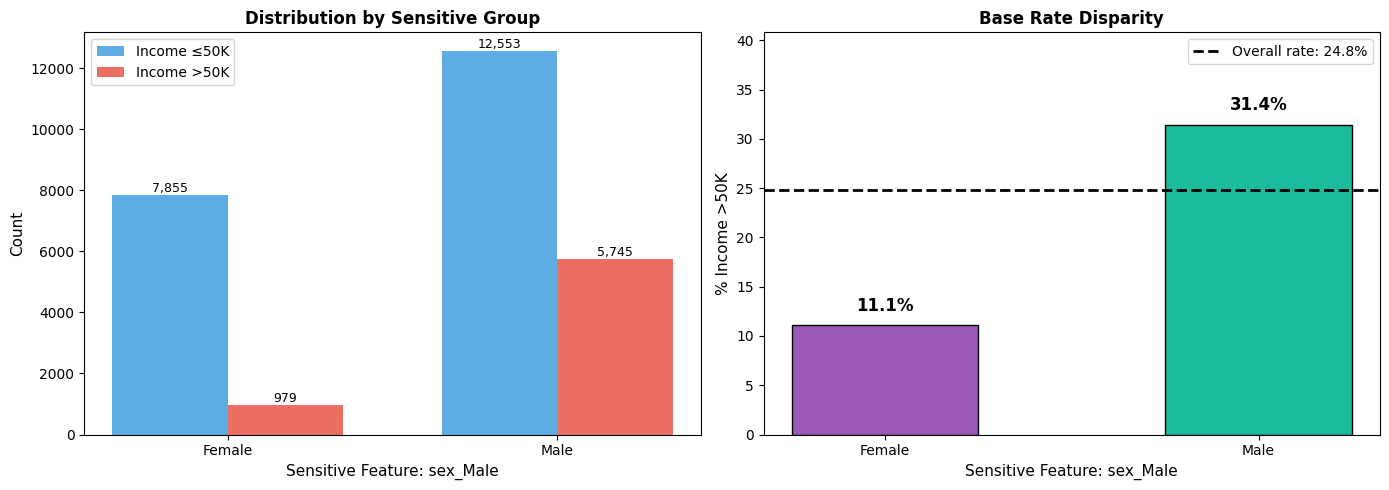


DISTRIBUTION SUMMARY

Sensitive Feature: sex_Male
Group                Count    % of Data    Base Rate
--------------------------------------------------
Female               8,834        32.6%        11.1%
Male                18,298        67.4%        31.4%
--------------------------------------------------
OVERALL             27,132       100.0%        24.8%

📊 Disparity Analysis:
   • Highest base rate: 31.4%
   • Lowest base rate:  11.1%
   • Disparity ratio:   2.83x
   • Absolute gap:      20.3 percentage points


In [71]:
# ============================================================================
# 1.1.2 DATA EXPLORATION - SEX
# ============================================================================

plot_sensitive_distribution(data_sex, DATASET_NAME, SENSITIVE_FEATURE_SEX)

### 1.2 Load Dataset

Load and preprocess the dataset with sensitive feature identification.

In [40]:
# Load dataset
data = load_dataset(DATASET_NAME, SENSITIVE_FEATURE)

# ============================================================================
# TRAIN / VALIDATION / TEST SPLIT
# ============================================================================
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
VAL_SIZE = 0.2  # 20% of remaining after test split = 16% of total
RANDOM_STATE = 42

X_full = data['X_train']
y_full = data['y_train']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y_full
)

# Second split: train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=VAL_SIZE / (1 - TEST_SIZE),  # Adjust to get desired val proportion
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Update data dict
data['X_train'] = X_train
data['y_train'] = y_train
data['X_val'] = X_val
data['y_val'] = y_val
data['X_test'] = X_test
data['y_test'] = y_test

print(f"Data Split:")
print(f"  Train:      {len(X_train):,} ({100*len(X_train)/len(X_full):.0f}%)")
print(f"  Validation: {len(X_val):,} ({100*len(X_val)/len(X_full):.0f}%)")
print(f"  Test:       {len(X_test):,} ({100*len(X_test)/len(X_full):.0f}%)")

Loading Adult Income from OpenML (ID: 179)...
APPROACH 1: Keeping sensitive features in training
  Sensitive feature for counterfactual: race_all
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Multiclass sensitive feature: race_all
  Columns (5): ['race_White', 'race_Black', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other']
  Indices: [41, 45, 42, 43, 44]

Final features (63): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 1):
  Samples: 45222, Features: 63
  Positive class ratio: 24.78%
Data Split:
  Train:      27,132 (60%)
  Validation: 9,045 (20%)
  Test:       9,045 (20%)


### 1.3 Data Exploration & Sensitive Feature Distribution

Understanding the distribution of outcomes across sensitive groups is crucial for fairness analysis. 
We examine:

1. **Base rate disparity** — Are positive outcomes distributed equally across sensitive groups?
2. **Sample sizes** — How many samples per sensitive group?
3. **Class imbalance** — Is there imbalance within each sensitive group?

These distributions reveal potential historical biases in the data that models may learn and amplify.

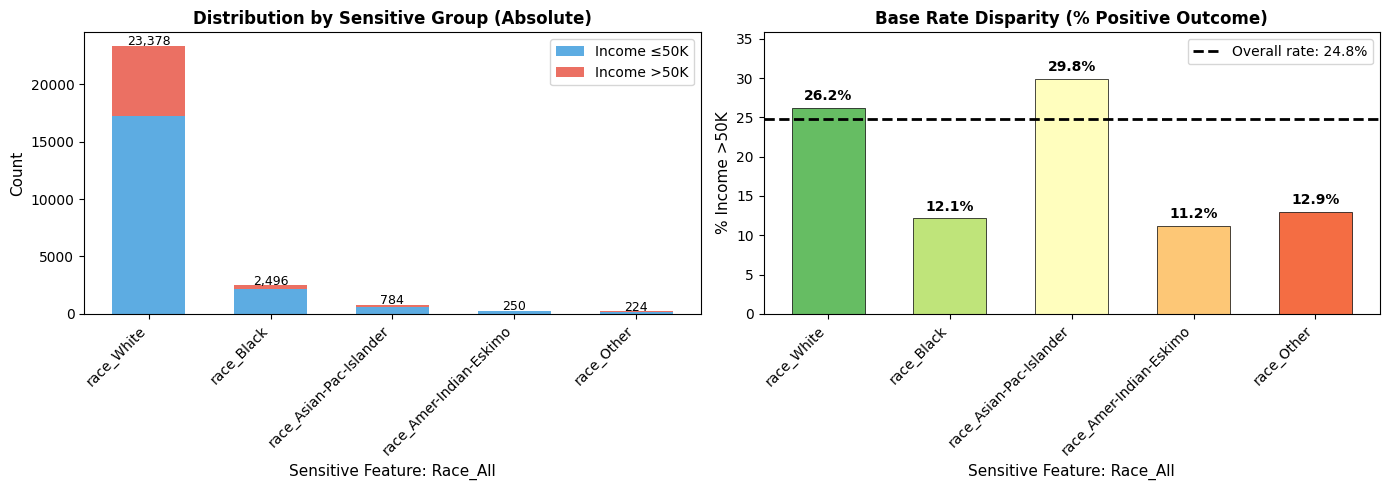


DISTRIBUTION SUMMARY

Sensitive Feature: race_all (5 categories)
Category             Count    % of Data    Base Rate
--------------------------------------------------
race_White          23,378        86.2%        26.2%
race_Black           2,496         9.2%        12.1%
race_Asian-Pac-Islander        784         2.9%        29.8%
race_Amer-Indian-Eskimo        250         0.9%        11.2%
race_Other             224         0.8%        12.9%
--------------------------------------------------
OVERALL             27,132       100.0%        24.8%

📊 Disparity Analysis:
   • Highest base rate: 29.8%
   • Lowest base rate:  11.2%
   • Disparity ratio:   2.66x
   • Absolute gap:      18.6 percentage points


In [41]:
# ============================================================================
# DATA EXPLORATION: Sensitive Feature vs Target Distribution
# ============================================================================

import matplotlib.pyplot as plt

is_multiclass = data.get('is_multiclass', False)

# Get target label names (customize based on dataset)
target_names = {0: 'Income ≤50K', 1: 'Income >50K'} if DATASET_NAME == 'adult' else {0: 'Class 0', 1: 'Class 1'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if is_multiclass:
    # Multiclass sensitive feature (e.g., race)
    sens_indices = data['sensitive_col_indices']
    sens_names = data['sensitive_col_names']
    n_categories = len(sens_names)
    
    # Determine which category each sample belongs to
    categories = np.argmax(X_train[:, sens_indices], axis=1)
    
    # Count samples per category and target
    category_target_counts = {}
    for cat_idx, cat_name in enumerate(sens_names):
        mask = (categories == cat_idx)
        pos_count = (y_train[mask] == 1).sum()
        neg_count = (y_train[mask] == 0).sum()
        category_target_counts[cat_name] = {'positive': pos_count, 'negative': neg_count, 'total': mask.sum()}
    
    # Plot 1: Stacked bar chart (absolute counts)
    cat_names = list(category_target_counts.keys())
    pos_counts = [category_target_counts[c]['positive'] for c in cat_names]
    neg_counts = [category_target_counts[c]['negative'] for c in cat_names]
    
    x = np.arange(len(cat_names))
    width = 0.6
    
    bars1 = axes[0].bar(x, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
    bars2 = axes[0].bar(x, pos_counts, width, bottom=neg_counts, label=target_names[1], color='#e74c3c', alpha=0.8)
    
    axes[0].set_xlabel(f'Sensitive Feature: {SENSITIVE_FEATURE.title()}', fontsize=11)
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].set_title('Distribution by Sensitive Group (Absolute)', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cat_names, rotation=45, ha='right')
    axes[0].legend()
    
    # Add count labels
    for i, (neg, pos) in enumerate(zip(neg_counts, pos_counts)):
        axes[0].annotate(f'{neg+pos:,}', (i, neg+pos+50), ha='center', fontsize=9)
    
    # Plot 2: Base rate (percentage positive) per group
    base_rates = [100 * category_target_counts[c]['positive'] / category_target_counts[c]['total'] 
                  for c in cat_names]
    
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(cat_names)))
    bars = axes[1].bar(x, base_rates, width, color=colors, edgecolor='black', linewidth=0.5)
    
    axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                    label=f'Overall rate: {100*y_train.mean():.1f}%')
    axes[1].set_xlabel(f'Sensitive Feature: {SENSITIVE_FEATURE.title()}', fontsize=11)
    axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
    axes[1].set_title('Base Rate Disparity (% Positive Outcome)', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cat_names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, max(base_rates) * 1.2)
    
    # Add percentage labels
    for i, rate in enumerate(base_rates):
        axes[1].annotate(f'{rate:.1f}%', (i, rate + 1), ha='center', fontsize=10, fontweight='bold')

else:
    # Binary sensitive feature (e.g., sex)
    sens_idx = data['sensitive_col_idx']
    sens_name = data['sensitive_col_name']
    
    # Get group labels (customize based on feature)
    if 'sex' in sens_name.lower():
        group_names = {0: 'Female', 1: 'Male'}
    else:
        group_names = {0: f'{sens_name}=0', 1: f'{sens_name}=1'}
    
    # Count samples per group and target
    group0_mask = (X_train[:, sens_idx] == 0)
    group1_mask = (X_train[:, sens_idx] == 1)
    
    counts = {
        group_names[0]: {'positive': (y_train[group0_mask] == 1).sum(), 
                         'negative': (y_train[group0_mask] == 0).sum(),
                         'total': group0_mask.sum()},
        group_names[1]: {'positive': (y_train[group1_mask] == 1).sum(), 
                         'negative': (y_train[group1_mask] == 0).sum(),
                         'total': group1_mask.sum()}
    }
    
    # Plot 1: Grouped bar chart
    grp_names = list(counts.keys())
    x = np.arange(len(grp_names))
    width = 0.35
    
    neg_counts = [counts[g]['negative'] for g in grp_names]
    pos_counts = [counts[g]['positive'] for g in grp_names]
    
    bars1 = axes[0].bar(x - width/2, neg_counts, width, label=target_names[0], color='#3498db', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, pos_counts, width, label=target_names[1], color='#e74c3c', alpha=0.8)
    
    axes[0].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].set_title('Distribution by Sensitive Group', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(grp_names)
    axes[0].legend()
    
    # Add count labels
    for bar in bars1:
        axes[0].annotate(f'{int(bar.get_height()):,}', 
                         (bar.get_x() + bar.get_width()/2, bar.get_height()),
                         ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        axes[0].annotate(f'{int(bar.get_height()):,}', 
                         (bar.get_x() + bar.get_width()/2, bar.get_height()),
                         ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Base rate comparison
    base_rates = [100 * counts[g]['positive'] / counts[g]['total'] for g in grp_names]
    
    colors = ['#9b59b6', '#1abc9c']
    bars = axes[1].bar(x, base_rates, width=0.5, color=colors, edgecolor='black', linewidth=1)
    
    axes[1].axhline(y=100*y_train.mean(), color='black', linestyle='--', linewidth=2, 
                    label=f'Overall rate: {100*y_train.mean():.1f}%')
    axes[1].set_xlabel(f'Sensitive Feature: {sens_name}', fontsize=11)
    axes[1].set_ylabel(f'% {target_names[1]}', fontsize=11)
    axes[1].set_title('Base Rate Disparity', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(grp_names)
    axes[1].legend()
    axes[1].set_ylim(0, max(base_rates) * 1.3)
    
    # Add percentage labels
    for i, rate in enumerate(base_rates):
        axes[1].annotate(f'{rate:.1f}%', (i, rate + 1.5), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DISTRIBUTION SUMMARY")
print("="*60)

if is_multiclass:
    print(f"\nSensitive Feature: {SENSITIVE_FEATURE} ({n_categories} categories)")
    print(f"{'Category':<15} {'Count':>10} {'% of Data':>12} {'Base Rate':>12}")
    print("-"*50)
    for cat_name in cat_names:
        c = category_target_counts[cat_name]
        pct_data = 100 * c['total'] / len(y_train)
        base_rate = 100 * c['positive'] / c['total']
        print(f"{cat_name:<15} {c['total']:>10,} {pct_data:>11.1f}% {base_rate:>11.1f}%")
else:
    print(f"\nSensitive Feature: {sens_name}")
    print(f"{'Group':<15} {'Count':>10} {'% of Data':>12} {'Base Rate':>12}")
    print("-"*50)
    for grp_name in grp_names:
        c = counts[grp_name]
        pct_data = 100 * c['total'] / len(y_train)
        base_rate = 100 * c['positive'] / c['total']
        print(f"{grp_name:<15} {c['total']:>10,} {pct_data:>11.1f}% {base_rate:>11.1f}%")

print("-"*50)
print(f"{'OVERALL':<15} {len(y_train):>10,} {'100.0%':>12} {100*y_train.mean():>11.1f}%")

# Calculate disparity
if is_multiclass:
    rates = [category_target_counts[c]['positive'] / category_target_counts[c]['total'] for c in cat_names]
else:
    rates = [counts[g]['positive'] / counts[g]['total'] for g in grp_names]

disparity_ratio = max(rates) / min(rates)
disparity_diff = 100 * (max(rates) - min(rates))

print(f"\n📊 Disparity Analysis:")
print(f"   • Highest base rate: {100*max(rates):.1f}%")
print(f"   • Lowest base rate:  {100*min(rates):.1f}%")
print(f"   • Disparity ratio:   {disparity_ratio:.2f}x")
print(f"   • Absolute gap:      {disparity_diff:.1f} percentage points")

## 2. Multi-Objective Optimization

Run SMAC (Sequential Model-based Algorithm Configuration) to find Pareto-optimal hyperparameter configurations that balance accuracy and fairness.

In [42]:
%%time

# Run optimization OR load from cache
if LOAD_FROM_CACHE:
    print("Loading results from cache...")
    results = load_smac_results(DATASET_NAME, SENSITIVE_FEATURE, approach=1)
else:
    print("Running SMAC optimization...")
    results = {}
    
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()}...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data,
            walltime_limit=WALLTIME_LIMIT,
            n_trials=N_TRIALS,
            output_dir="../smac_output"
        )
        results[model_type] = smac
    
    print("\n" + "="*60)
    print("Optimization complete!")
    print("="*60)
    
    # Save results to cache for future use
    save_smac_results(results, DATASET_NAME, SENSITIVE_FEATURE, approach=1)

Running SMAC optimization...

Optimizing RF...

Running SMAC optimization for RF (Approach 1)
Training samples: 27,132
Validation samples: 9,045
Using MULTICLASS counterfactual (exhaustive, 5 categories)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 31471b is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config b559dc is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:596] Added config 30b752 and rejected config 65fa19 as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstrac

## 3. Results & Visualization

### 3.1 Pareto Front Analysis

The Pareto front shows the optimal trade-off between accuracy and counterfactual consistency. Points on the front represent configurations where improving one objective necessarily worsens the other.

- **X-axis**: Balanced Accuracy (higher = better predictions)
- **Y-axis**: Counterfactual Consistency (higher = more fair)
- **Pareto-optimal points**: Connected by dashed lines
- **Dominated points**: Lighter colored, suboptimal configurations

In [43]:
# Generate optimization summary table
import pandas as pd

def get_optimization_stats(smac, model_name):
    """Extract statistics from SMAC optimization run."""
    runhistory = smac.runhistory
    
    # Number of configurations evaluated
    n_configs = len(runhistory.get_configs())
    
    # Get Pareto front size (final incumbents)
    pareto_configs, pareto_costs = get_pareto_front(smac)
    n_incumbents = len(pareto_configs)
    
    # Calculate total time and average time per config
    # Sum up all trial times from runhistory
    total_time = 0
    for key, value in runhistory.items():
        if value.time is not None:
            total_time += value.time
    
    avg_time = total_time / n_configs if n_configs > 0 else 0
    
    return {
        'Model': model_name.upper(),
        'Configs Evaluated': n_configs,
        'Pareto Front Size': n_incumbents,
        'Total Time (s)': f"{total_time:.1f}",
        'Avg Time/Config (s)': f"{avg_time:.2f}",
    }

# Build summary table
summary_data = []
for model_type, smac in results.items():
    stats = get_optimization_stats(smac, model_type)
    summary_data.append(stats)

summary_df = pd.DataFrame(summary_data)

print("=" * 70)
print("OPTIMIZATION SUMMARY")
print("=" * 70)
display(summary_df)

# Additional insights
print("\n" + "=" * 70)
print("INSIGHTS")
print("=" * 70)
for model_type, smac in results.items():
    n_configs = len(smac.runhistory.get_configs())
    pareto_configs, _ = get_pareto_front(smac)
    pareto_pct = len(pareto_configs) / n_configs * 100 if n_configs > 0 else 0
    print(f"{model_type.upper()}: {len(pareto_configs)}/{n_configs} configs are Pareto-optimal ({pareto_pct:.1f}%)")


OPTIMIZATION SUMMARY


Model  Configs Evaluated  Pareto Front Size Total Time (s)  \
0    RF                101                  7           79.2   
1   MLP                 71                 11          294.3   

  Avg Time/Config (s)  
0                0.78  
1                4.15


INSIGHTS
RF: 7/101 configs are Pareto-optimal (6.9%)
MLP: 11/71 configs are Pareto-optimal (15.5%)


In [44]:
# The accuracy and consistency of the best configurations

print_pareto_summary(results)


PARETO FRONT SUMMARY

RF Pareto Front (7 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7718, Consistency=0.9799
  Config 2: Accuracy=0.7658, Consistency=0.9899
  Config 3: Accuracy=0.7643, Consistency=0.9994
  Config 4: Accuracy=0.7636, Consistency=0.9996
  Config 5: Accuracy=0.7635, Consistency=0.9999
  Config 6: Accuracy=0.7615, Consistency=1.0000
  Config 7: Accuracy=0.7615, Consistency=1.0000

  Best Accuracy: 0.7718 (Consistency: 0.9799)
  Best Consistency: 1.0000 (Accuracy: 0.7615)

MLP Pareto Front (11 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.8019, Consistency=0.9604
  Config 2: Accuracy=0.7931, Consistency=0.9685
  Config 3: Accuracy=0.7923, Consistency=0.9686
  Config 4: Accuracy=0.7872, Consistency=0.9687
  Config 5: Accuracy=0.7863, Consistency=0.9689
  Config 6: Accuracy=0.7862, Consistency=0.9745
  Config 7: Accuracy=0.7778, Consistency=0.9756
  Config 8: Accuracy=0.7742, Consis

[notebook] Pareto plot saved to: ../plots/notebook/pareto_adult_race_all.png
[latex] Pareto plot saved to: ../plots/latex/pareto_adult_race_all.png


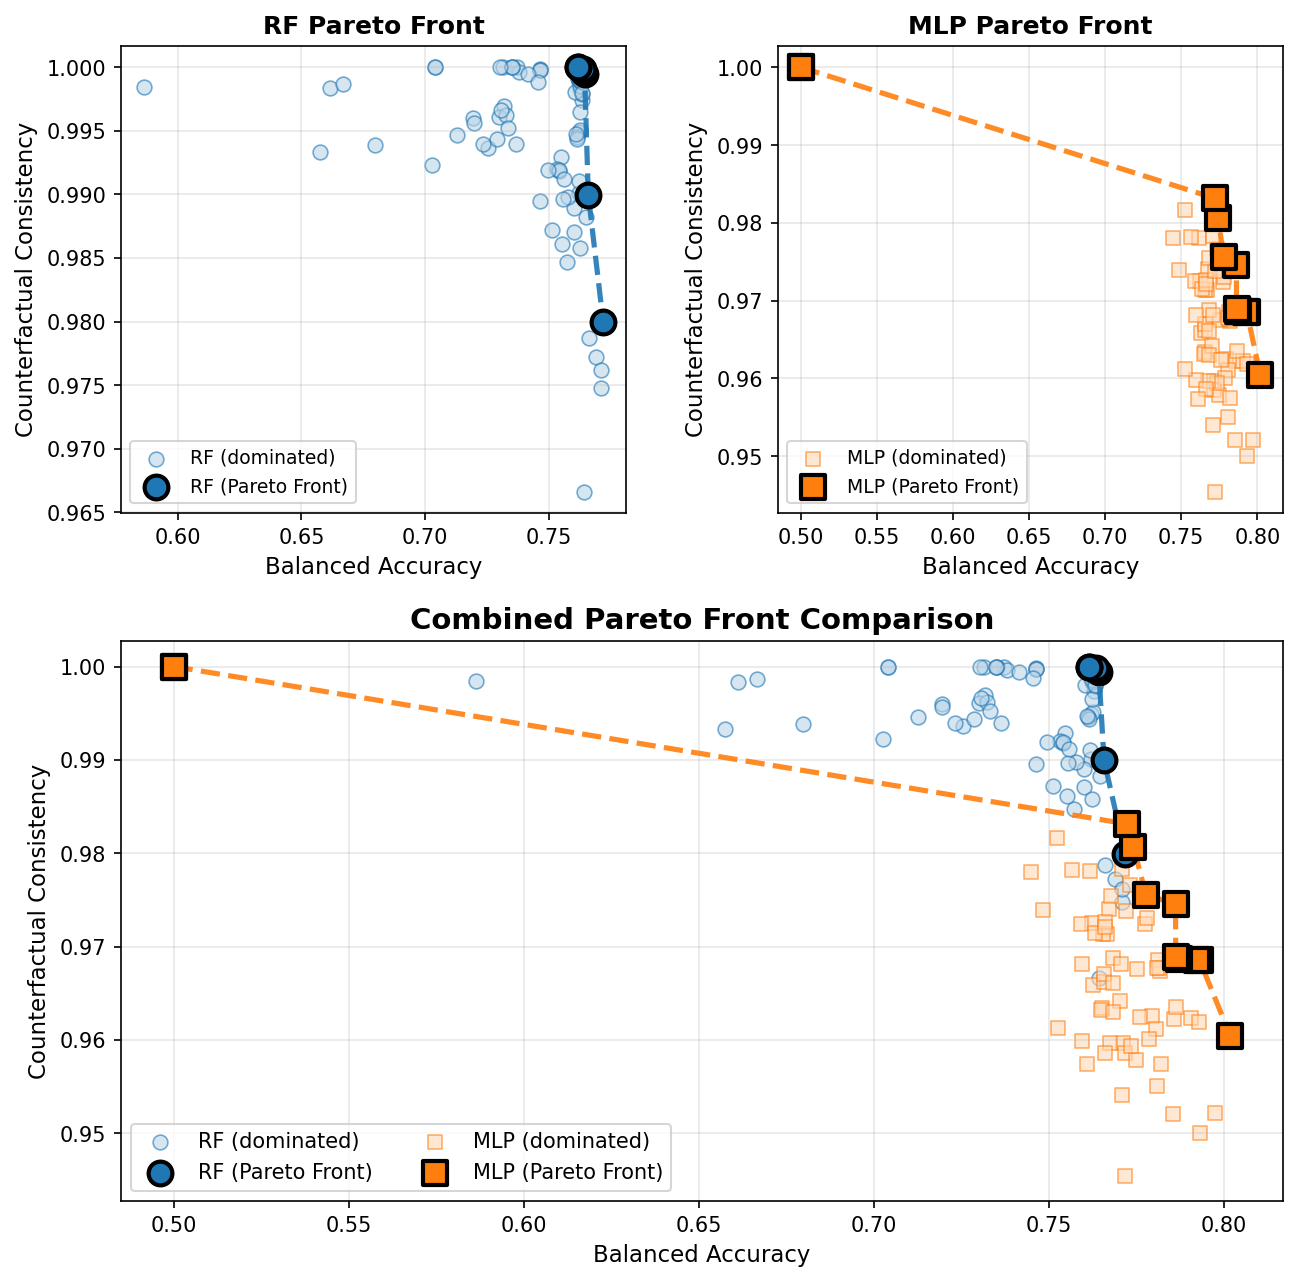

In [45]:
# Generate Pareto comparison plot (both notebook and latex versions)
pareto_filename = f"pareto_{DATASET_NAME}_{SENSITIVE_FEATURE}.png"
pareto_paths = plot_pareto_comparison(
    results, 
    output_dir=OUTPUT_DIR,
    filename=pareto_filename,
    formats=["notebook", "latex"]
)

# Display the notebook version
display(Image(filename=pareto_paths["notebook"]))

### 3.2 Parallel Coordinate Plots

Parallel coordinate plots visualize how hyperparameter configurations map to objective values.

| Element | Meaning |
|---------|---------|
| **Vertical axes** | Hyperparameters and objectives |
| **Lines** | Individual configurations |
| **Bold lines** | Pareto-optimal configurations |
| **Faint lines** | Dominated configurations |
| **Color** | Performance (green = better, red = worse) |

**Key insights:**
- Identify which hyperparameter ranges lead to better trade-offs
- Spot correlations between hyperparameters and objectives
- Assess diversity of the explored configuration space

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_rf.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_rf.png

Random Forest - Parallel Coordinate Plot:


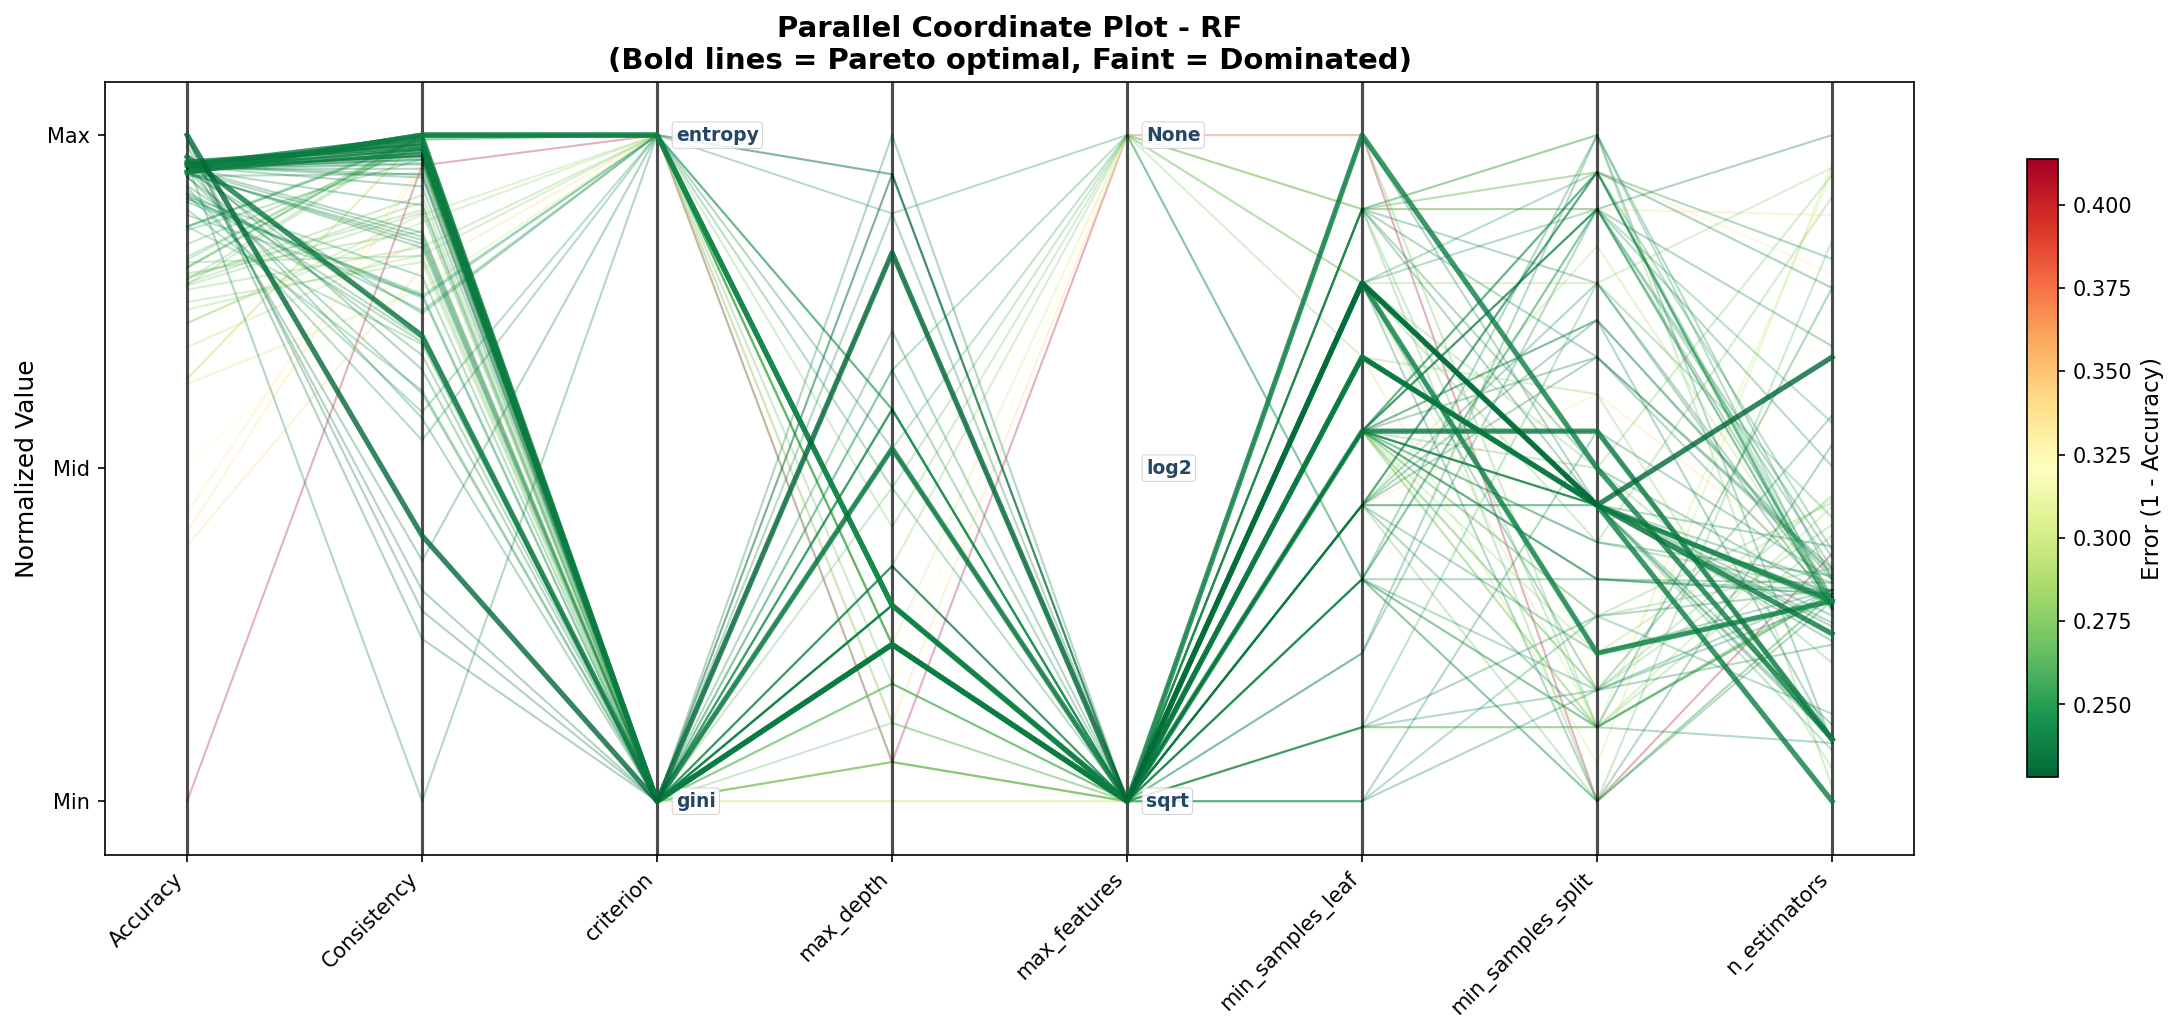

In [46]:
# Random Forest parallel coordinates (both notebook and latex versions)
rf_parallel_filename = f"parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
rf_parallel_paths = plot_parallel_coordinates(
    results['rf'], 
    'rf',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=rf_parallel_filename,
    color_by='error',
    formats=["notebook", "latex"]
)

print("\nRandom Forest - Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_paths["notebook"]))

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_adult_race_all_mlp.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_adult_race_all_mlp.png

MLP - Parallel Coordinate Plot:


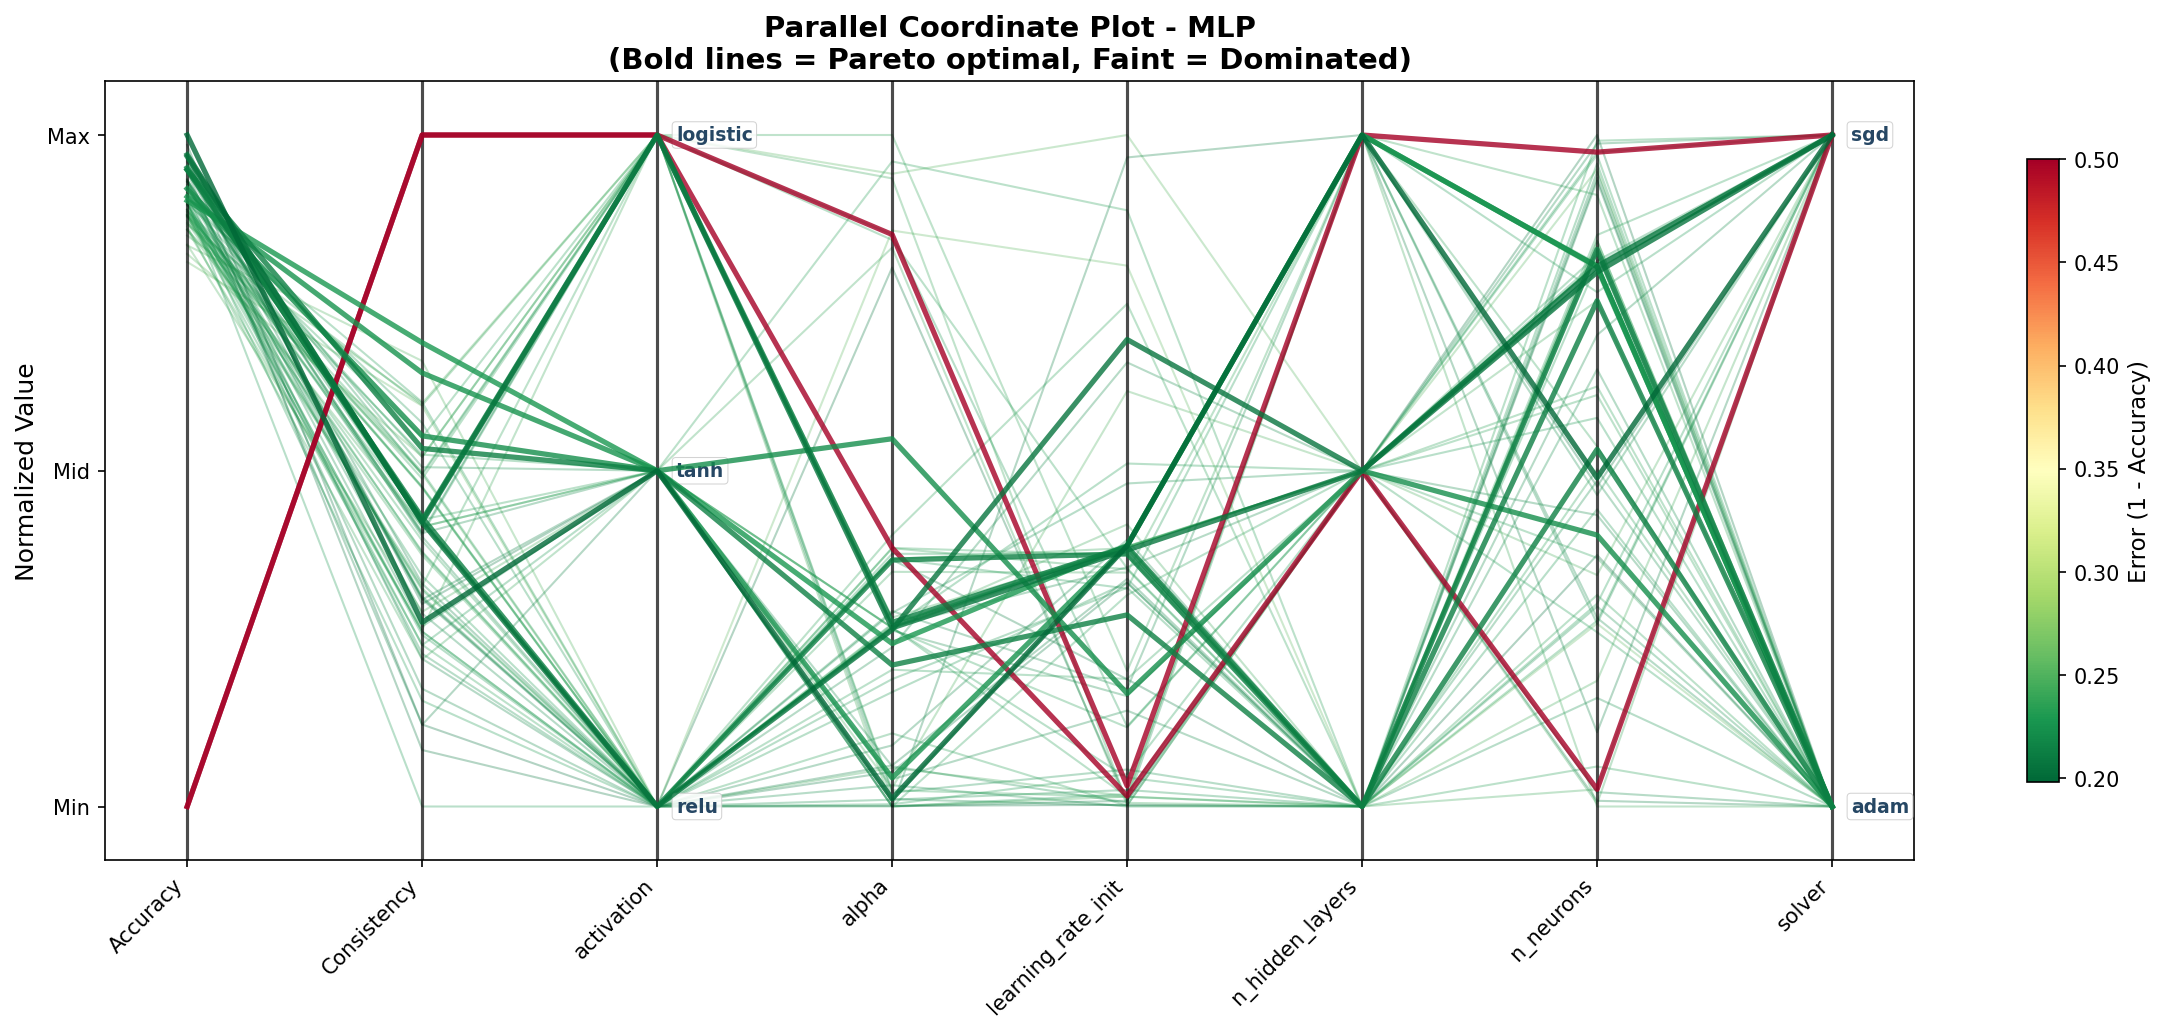

In [47]:
# MLP parallel coordinates (both notebook and latex versions)
mlp_parallel_filename = f"parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
mlp_parallel_paths = plot_parallel_coordinates(
    results['mlp'], 
    'mlp',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=mlp_parallel_filename,
    color_by='error',
    formats=["notebook", "latex"]
)

print("\nMLP - Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_paths["notebook"]))


### 3.3 MDS Projection

Multidimensional Scaling (MDS) projects the high-dimensional hyperparameter space into 2D while preserving pairwise distances between configurations.

| Element | Meaning |
|---------|---------|
| **Points** | Hyperparameter configurations |
| **Distance** | Similarity in hyperparameter values |
| **Background color** | Interpolated performance surface |
| **Red squares** | Pareto-optimal configurations |
| **White circles** | Non-Pareto configurations |

**Key insights:**
- Identify clusters of similar configurations
- See if high-performing configs are localized or spread out
- Understand the performance landscape structure

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_race_all_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_race_all_rf.png

Random Forest - MDS Projection:


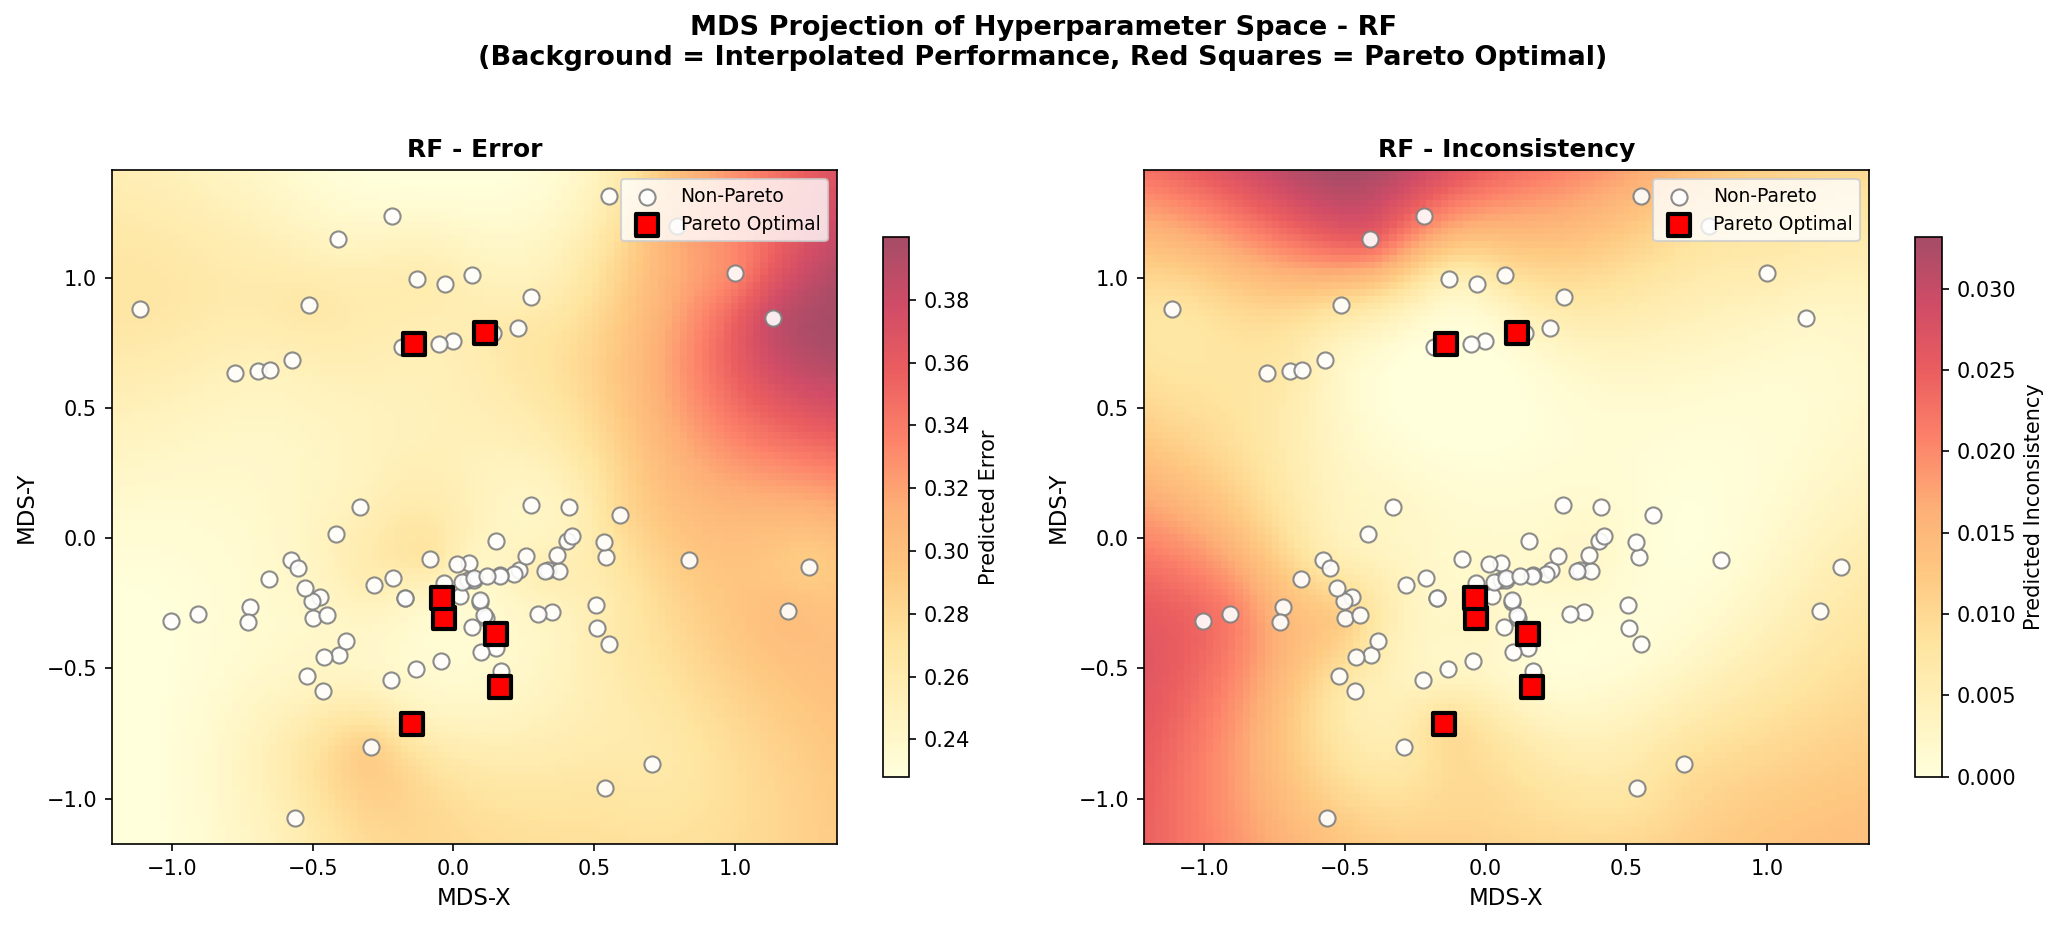

In [48]:
# Random Forest MDS projection (both notebook and latex versions)
rf_mds_filename = f"mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
rf_mds_paths = plot_mds_projection(
    results['rf'], 
    'rf',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=rf_mds_filename,
    formats=["notebook", "latex"]
)

print("\nRandom Forest - MDS Projection:")
display(Image(filename=rf_mds_paths["notebook"]))

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_adult_race_all_mlp.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_adult_race_all_mlp.png

MLP - MDS Projection:


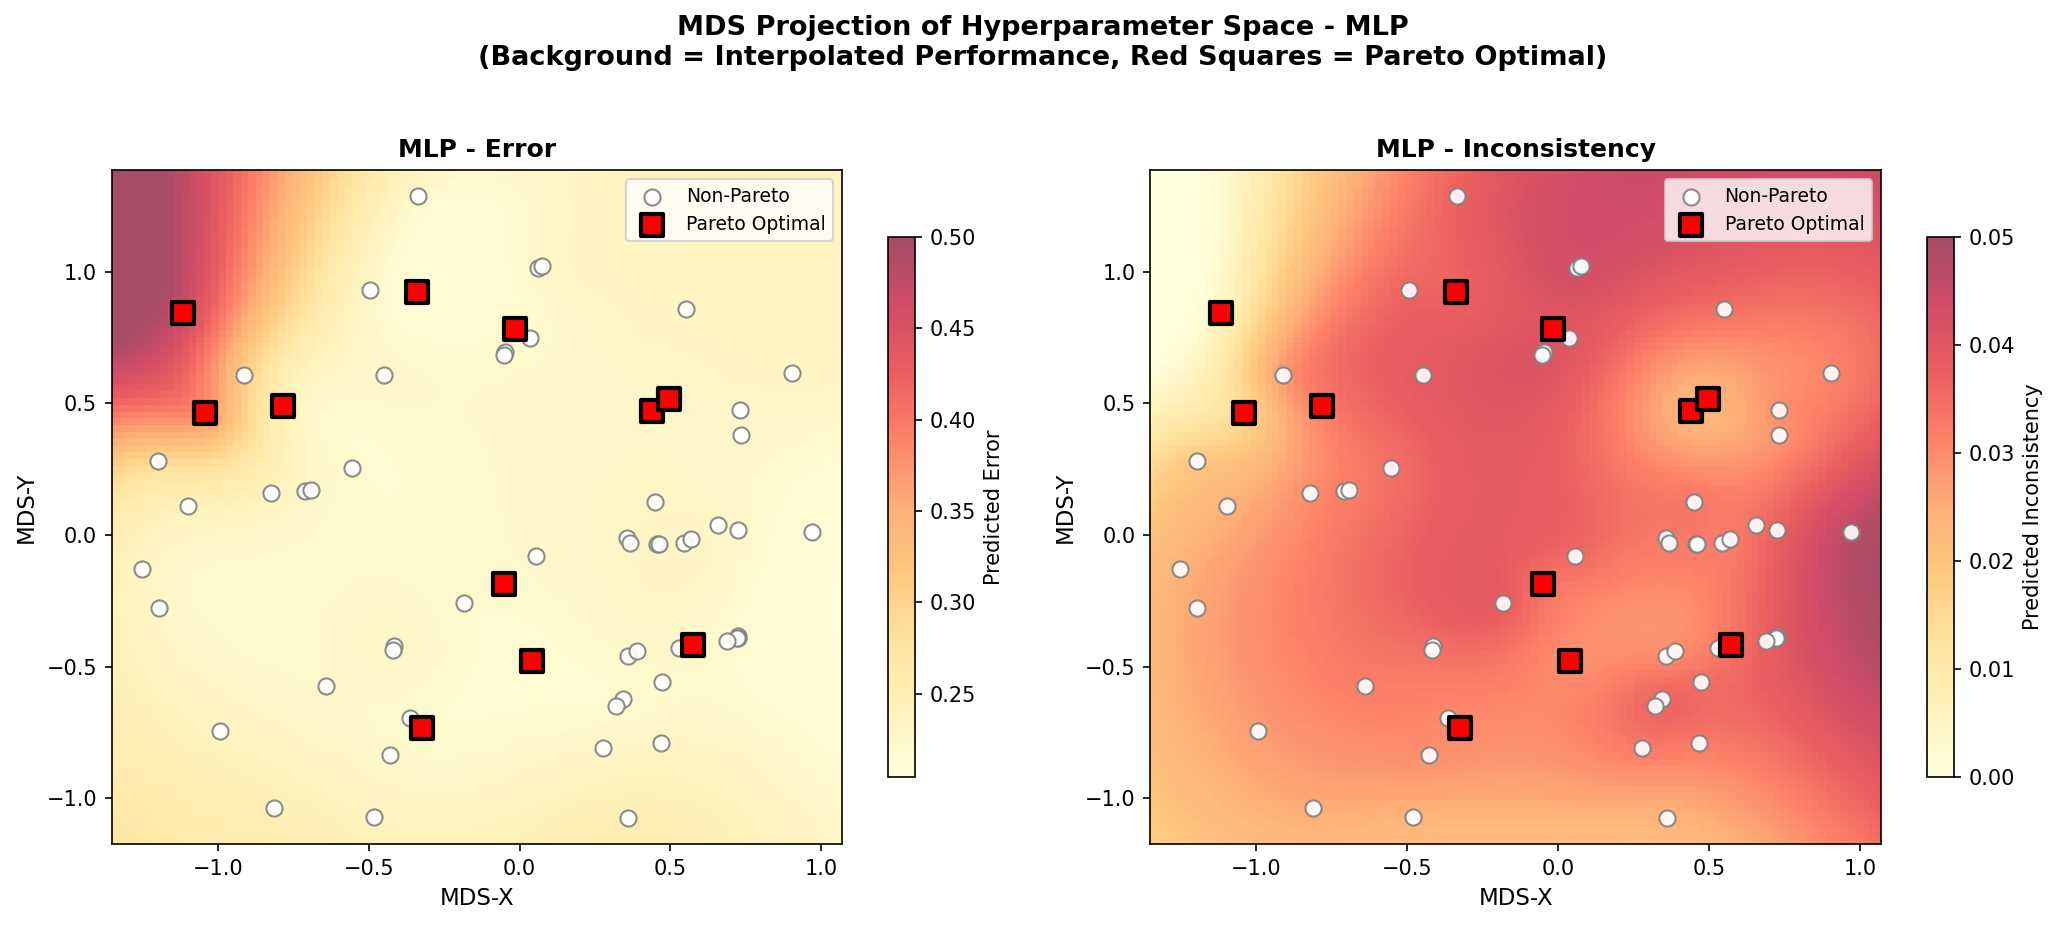

In [49]:
# MLP MDS projection (both notebook and latex versions)
mlp_mds_filename = f"mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
mlp_mds_paths = plot_mds_projection(
    results['mlp'], 
    'mlp',
    get_configspace_fn=get_configspace,
    output_dir=OUTPUT_DIR,
    filename=mlp_mds_filename,
    formats=["notebook", "latex"]
)

print("\nMLP - MDS Projection:")
display(Image(filename=mlp_mds_paths["notebook"]))


### 3.4 Fairness-Accuracy Confusion Matrix

Analyzes the joint distribution of prediction correctness and counterfactual consistency at the sample level.

|                        | **Consistent** | **Inconsistent** |
|------------------------|----------------|------------------|
| **Correct Prediction** | ✅ Ideal | ⚠️ Right but Unfair |
| **Wrong Prediction**   | 🔸 Fair Error | ❌ Worst Case |

**Key metrics:**
- P(Consistent | Correct): Are correct predictions more likely to be fair?
- P(Correct | Inconsistent): Are unfair predictions more likely to be wrong?

This reveals whether fairness and accuracy are aligned or in tension for this model.


Analyzing RF - Best Accuracy Configuration
Config: {'criterion': np.str_('gini'), 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 134}
Accuracy: 0.7718
Consistency: 0.9799

FAIRNESS-ACCURACY CONFUSION MATRIX: RF (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7598             137       7735
Wrong Prediction                1201             109       1310
------------------------------------------------------------
Total                           8799             246       9045

📈 Key Metrics:
  • Accuracy:    85.52%
  • Consistency: 97.28%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   98.23%
  • P(Consistent | Wrong):     91.68%
  • P(Correct | Consistent):   86.35%
  • P(Correct | Inconsistent): 55.69%

💡 Interpretation:
  → Correct predictions are 6.5% more likely to be co

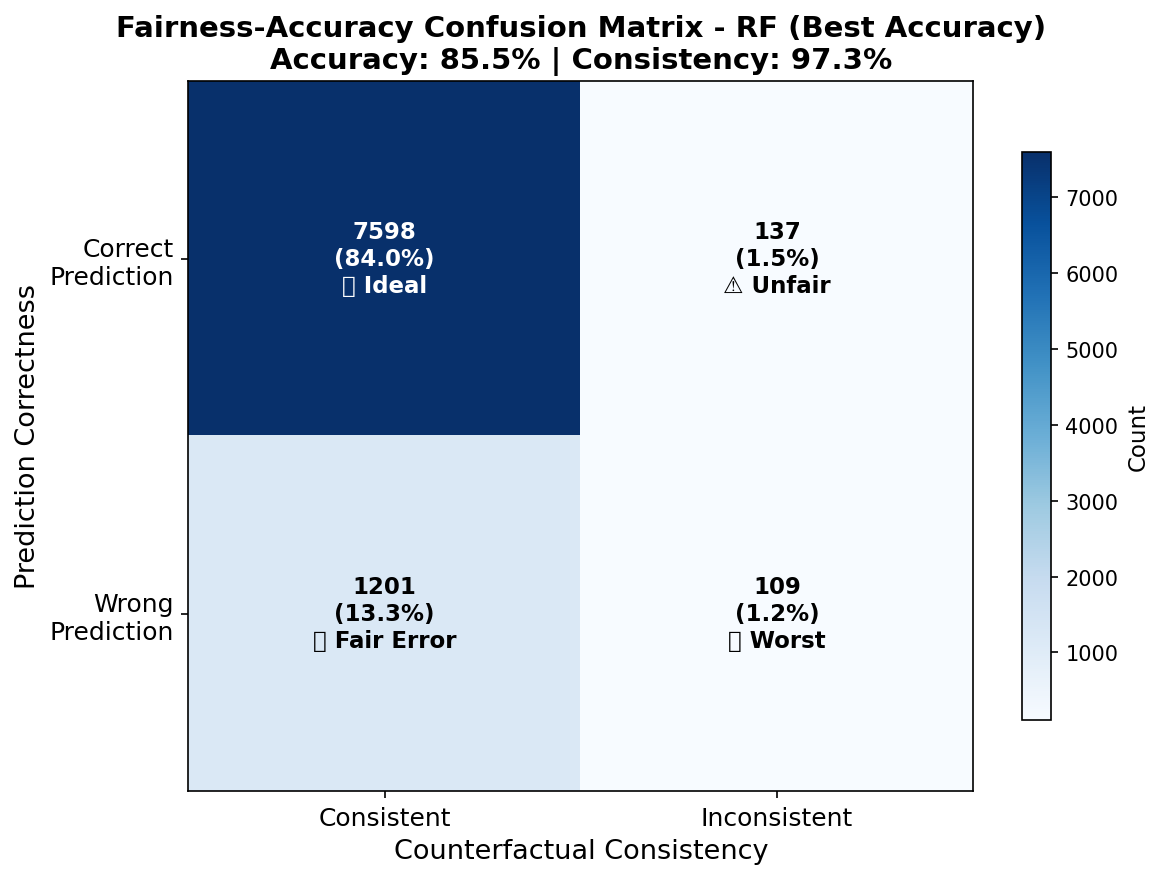


Analyzing MLP - Best Accuracy Configuration
Config: {'activation': np.str_('tanh'), 'alpha': 0.0011212223721, 'learning_rate_init': 0.0374175904372, 'n_hidden_layers': 3, 'n_neurons': 136, 'solver': np.str_('sgd')}
Accuracy: 0.8019
Consistency: 0.9604

FAIRNESS-ACCURACY CONFUSION MATRIX: MLP (Best Accuracy)

📊 Matrix (Counts):
                          Consistent    Inconsistent      Total
------------------------------------------------------------
Correct Prediction              7336             387       7723
Wrong Prediction                 953             369       1322
------------------------------------------------------------
Total                           8289             756       9045

📈 Key Metrics:
  • Accuracy:    85.38%
  • Consistency: 91.64%

🔍 Conditional Probabilities:
  • P(Consistent | Correct):   94.99%
  • P(Consistent | Wrong):     72.09%
  • P(Correct | Consistent):   88.50%
  • P(Correct | Inconsistent): 51.19%

💡 Interpretation:
  → Correct predictions are

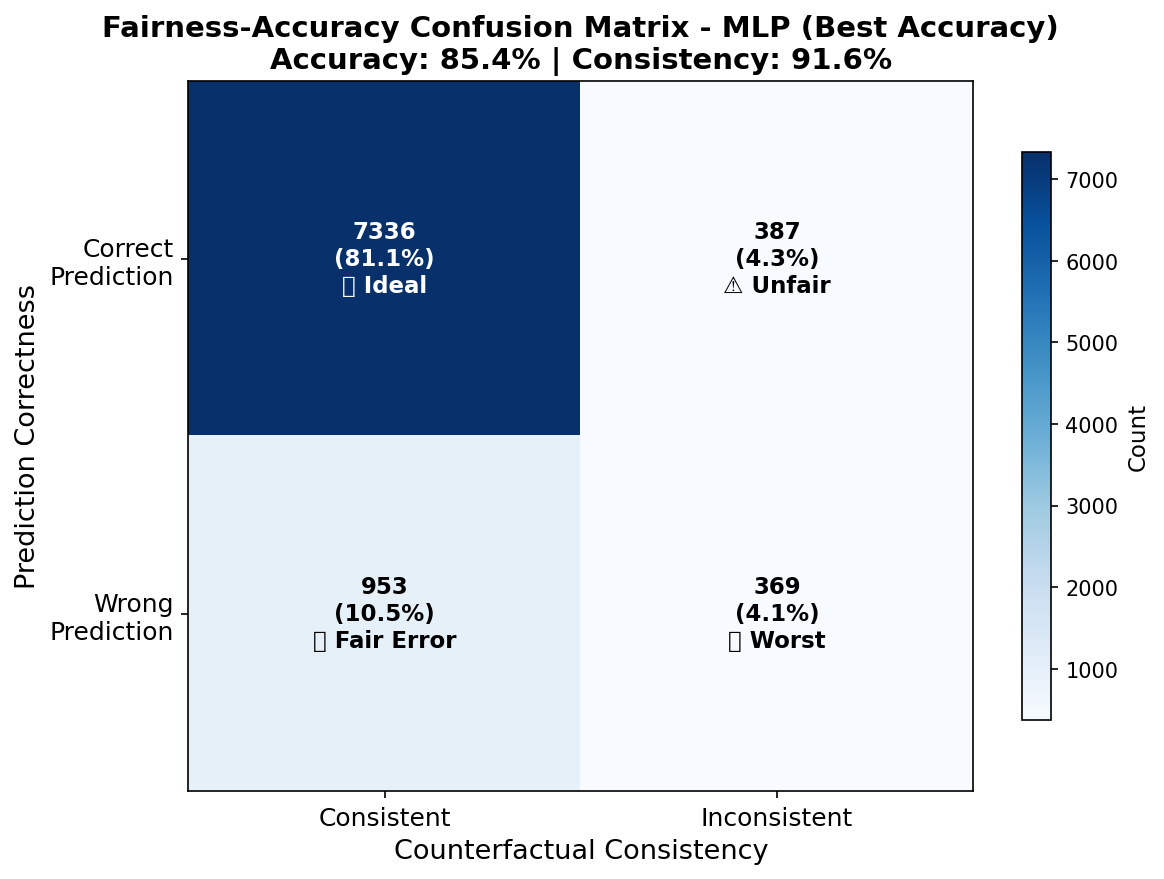

In [52]:
# ============================================================================
# Fairness-Accuracy Confusion Matrix Analysis
# ============================================================================
# Analyze the relationship between correctness and consistency for each model
# Using the best accuracy configuration from the Pareto front
# Evaluated on VALIDATION set (same data SMAC used for scoring)

for model_type in ["rf", "mlp"]:
    print(f"\n{'='*70}")
    print(f"Analyzing {model_type.upper()} - Best Accuracy Configuration")
    print(f"{'='*70}")
    
    # Get best accuracy config from Pareto front
    configs, costs = get_pareto_front(results[model_type])
    best_acc_idx = np.argmin(costs[:, 0])  # Lowest error = best accuracy
    best_config = configs[best_acc_idx]
    
    print(f"Config: {dict(best_config)}")
    print(f"Accuracy: {1 - costs[best_acc_idx, 0]:.4f}")
    print(f"Consistency: {1 - costs[best_acc_idx, 1]:.4f}")
    
    # Create and train the model on TRAINING set
    if model_type == "rf":
        model = create_rf_model(best_config)
    else:
        model = create_mlp_model(best_config)
    
    model.fit(data['X_train'], data['y_train'])
    
    # Compute fairness confusion matrix on VALIDATION set
    if data.get('is_multiclass', False):
        fcm_results = compute_fairness_confusion_matrix(
            model, data['X_val'], data['y_val'],  # Changed to validation
            sensitive_col_indices=data['sensitive_col_indices'],
            is_multiclass=True
        )
    else:
        fcm_results = compute_fairness_confusion_matrix(
            model, data['X_val'], data['y_val'],  # Changed to validation
            sensitive_col_idx=data['sensitive_col_idx'],
            is_multiclass=False
        )
    
    # Print summary
    print_fairness_confusion_summary(fcm_results, f"{model_type.upper()} (Best Accuracy)")
    
    # Plot and save
    fcm_paths = plot_fairness_confusion_matrix(
        fcm_results,
        model_name=f"{model_type.upper()} (Best Accuracy)",
        output_dir=OUTPUT_DIR,
        filename=f"fairness_confusion_{DATASET_NAME}_{SENSITIVE_FEATURE}_{model_type}_best_acc.png",
        formats=["notebook", "latex"]
    )
    
    # Display
    display(Image(filename=fcm_paths["notebook"]))

## 4. Analysis & Deep Dives

### 4.1 Investigating the "Trivially Fair" MLP

During optimization, SMAC found an MLP configuration achieving **100% consistency but only 50% accuracy**. This section investigates why this happens and confirms it's a degenerate solution.

In [51]:
# Investigate the "trivially fair" MLP configuration
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

# Get the fairest (but degenerate) MLP config from Pareto front
configs, costs = get_pareto_front(results['mlp'])
best_fair_idx = np.argmin(costs[:, 1])
fair_config = configs[best_fair_idx]

print("="*70)
print("TRIVIALLY FAIR MLP ANALYSIS")
print("="*70)

# The problematic configuration
fairest_config = {
    'hidden_layer_sizes': tuple([fair_config["n_neurons"]] * fair_config["n_hidden_layers"]),
    'activation': fair_config["activation"],
    'solver': fair_config["solver"],
    'alpha': fair_config["alpha"],
    'learning_rate_init': fair_config["learning_rate_init"],
    'max_iter': 500,
    'early_stopping': True,
    'random_state': 42
}

print(f"\nConfiguration: {fair_config['activation']} activation, {fair_config['solver']} solver")
print(f"Learning rate: {fair_config['learning_rate_init']:.4f}, Alpha: {fair_config['alpha']:.4f}")

# Train on TRAINING set, evaluate on VALIDATION set
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

# Train with original config (logistic/sigmoid activation)
model_logistic = MLPClassifier(**fairest_config)
model_logistic.fit(X_train, y_train)
y_pred_logistic = model_logistic.predict(X_val)  # Evaluate on validation
acc_logistic = balanced_accuracy_score(y_val, y_pred_logistic)

print(f"\n--- With LOGISTIC (sigmoid) activation ---")
print(f"Unique predictions: {np.unique(y_pred_logistic)} → Predicts only ONE class!")
print(f"Balanced Accuracy: {acc_logistic:.1%} (= random guessing)")
print(f"Training iterations: {model_logistic.n_iter_}")

# Now test with ReLU - the fix
relu_config = fairest_config.copy()
relu_config['activation'] = 'relu'

model_relu = MLPClassifier(**relu_config)
model_relu.fit(X_train, y_train)
y_pred_relu = model_relu.predict(X_val)  # Evaluate on validation
acc_relu = balanced_accuracy_score(y_val, y_pred_relu)

print(f"\n--- With ReLU activation (same other params) ---")
print(f"Unique predictions: {np.unique(y_pred_relu)} → Predicts BOTH classes!")
print(f"Balanced Accuracy: {acc_relu:.1%} (meaningful!)")
print(f"Training iterations: {model_relu.n_iter_}")

print(f"\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print(f"→ Sigmoid activation caused vanishing gradients (gradient ≤ 0.25)")
print(f"→ Network never learned → constant predictions → 'trivial' 100% fairness")
print(f"→ ReLU fixes this: accuracy improves from {acc_logistic:.1%} to {acc_relu:.1%}")
print(f"\n⚠️  High fairness + low accuracy = likely a degenerate solution!")

TRIVIALLY FAIR MLP ANALYSIS

Configuration: logistic activation, sgd solver
Learning rate: 0.0017, Alpha: 0.0367

--- With LOGISTIC (sigmoid) activation ---
Unique predictions: [0] → Predicts only ONE class!
Balanced Accuracy: 50.0% (= random guessing)
Training iterations: 12

--- With ReLU activation (same other params) ---
Unique predictions: [0 1] → Predicts BOTH classes!
Balanced Accuracy: 77.0% (meaningful!)
Training iterations: 91

CONCLUSION:
→ Sigmoid activation caused vanishing gradients (gradient ≤ 0.25)
→ Network never learned → constant predictions → 'trivial' 100% fairness
→ ReLU fixes this: accuracy improves from 50.0% to 77.0%

⚠️  High fairness + low accuracy = likely a degenerate solution!


### Summary: The "Trivial Fairness" Problem

#### The Configuration

| Hyperparameter | Value | Impact |
|---------------|-------|--------|
| `activation` | `logistic` (sigmoid) | **Main culprit** - causes vanishing gradients |
| `solver` | `sgd` | No momentum to escape flat regions |
| `learning_rate_init` | ~0.002 | Very low - tiny weight updates |
| `alpha` | ~0.04 | High L2 regularization - pushes weights to zero |
| `hidden_layer_sizes` | 2 layers | Gradients multiply through both |

#### Root Cause: Vanishing Gradient Problem

The sigmoid activation function has a maximum gradient of only 0.25:

$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$$

In a 2-layer network, gradients compound:

$$\text{Effective gradient} \approx 0.25 \times 0.25 = 0.0625 \text{ (6.25\% of original)}$$

#### Why This Matters for Fairness Research

This is a **false positive for fairness**: the model achieves perfect consistency not because it learned to be fair, but because it **learned nothing at all**. A constant predictor trivially satisfies:

$$\text{Consistency} = \frac{\sum \mathbb{1}[f(x) = f(x')]}{n} = 1.0 \quad \text{when } f(x) = c \text{ for all } x$$

#### Key Takeaway

> ⚠️ **When evaluating fairness metrics, always check model accuracy first.** A model with very high fairness but near-random accuracy may be a degenerate solution that provides no value.

#### Verification

Changing **only** the activation from `logistic` to `relu` (keeping all else the same) allows the network to learn:
- ReLU gradient = 1 (for positive inputs) vs sigmoid's max of 0.25
- The model achieves ~75% accuracy with the same hyperparameters
- This confirms the sigmoid activation was the bottleneck

### 4.2 Case Study: Sample-Level Fairness Analysis

This section analyzes individual samples to understand how counterfactual consistency manifests at the sample level. We examine:

1. **Prediction flips** — Samples where changing the sensitive attribute changes the prediction
2. **Consistent samples** — Samples robust to sensitive attribute changes
3. **Edge cases** — Samples near the decision boundary (most vulnerable to bias)
4. **Model comparison** — How RF and MLP differ in their fairness behavior
5. **Probability sensitivity** — How much predictions shift even without flipping

In [53]:
# ============================================================================
# SETUP: Train models and prepare counterfactual analysis
# ============================================================================
# Models are trained on TRAINING set, evaluated on VALIDATION set
# This matches what SMAC did during optimization

# Get best accuracy configs from Pareto front
rf_configs, rf_costs = get_pareto_front(results['rf'])
mlp_configs, mlp_costs = get_pareto_front(results['mlp'])

rf_best_acc_idx = np.argmin(rf_costs[:, 0])
mlp_best_acc_idx = np.argmin(mlp_costs[:, 0])

rf_config = rf_configs[rf_best_acc_idx]
mlp_config = mlp_configs[mlp_best_acc_idx]

print("Selected Models (Best Accuracy from Pareto Front):")
print(f"  RF:  Accuracy={1-rf_costs[rf_best_acc_idx, 0]:.4f}, Consistency={1-rf_costs[rf_best_acc_idx, 1]:.4f}")
print(f"  MLP: Accuracy={1-mlp_costs[mlp_best_acc_idx, 0]:.4f}, Consistency={1-mlp_costs[mlp_best_acc_idx, 1]:.4f}")

# Create and train models on TRAINING set
rf_model = create_rf_model(rf_config)
mlp_model = create_mlp_model(mlp_config)

rf_model.fit(data['X_train'], data['y_train'])
mlp_model.fit(data['X_train'], data['y_train'])

# Use VALIDATION set for analysis (same data SMAC used for scoring!)
X_val = data['X_val']
y_val = data['y_val']

# Original predictions and probabilities on VALIDATION set
rf_pred_orig = rf_model.predict(X_val)
rf_proba_orig = rf_model.predict_proba(X_val)[:, 1]
mlp_pred_orig = mlp_model.predict(X_val)
mlp_proba_orig = mlp_model.predict_proba(X_val)[:, 1]

# ============================================================================
# Create flipped data - HANDLE MULTICLASS PROPERLY
# ============================================================================
is_multiclass = data.get('is_multiclass', False)

if is_multiclass:
    from utils.datasets import create_flipped_data_multiclass_exhaustive
    flipped_versions, original_categories = create_flipped_data_multiclass_exhaustive(
        X_val, data['sensitive_col_indices']
    )
    n_categories = len(data['sensitive_col_indices'])
    sens_names = data['sensitive_col_names']
    
    # Compute predictions for ALL flipped versions
    rf_preds_flipped = [rf_model.predict(fv) for fv in flipped_versions]
    rf_probas_flipped = [rf_model.predict_proba(fv)[:, 1] for fv in flipped_versions]
    
    mlp_preds_flipped = [mlp_model.predict(fv) for fv in flipped_versions]
    mlp_probas_flipped = [mlp_model.predict_proba(fv)[:, 1] for fv in flipped_versions]
    
    # Compute TRUE multiclass consistency (consistent across ALL flips)
    rf_inconsistent = np.zeros(len(X_val), dtype=bool)
    mlp_inconsistent = np.zeros(len(X_val), dtype=bool)
    
    for target_cat in range(n_categories):
        is_actual_flip = (original_categories != target_cat)
        rf_inconsistent |= (is_actual_flip & (rf_pred_orig != rf_preds_flipped[target_cat]))
        mlp_inconsistent |= (is_actual_flip & (mlp_pred_orig != mlp_preds_flipped[target_cat]))
    
    # For probability analysis
    rf_proba_changes = np.array([np.abs(rf_probas_flipped[i] - rf_proba_orig) for i in range(n_categories)])
    mlp_proba_changes = np.array([np.abs(mlp_probas_flipped[i] - mlp_proba_orig) for i in range(n_categories)])
    
    rf_proba_change = rf_proba_changes.max(axis=0)
    mlp_proba_change = mlp_proba_changes.max(axis=0)
    
    rf_max_flip_target = rf_proba_changes.argmax(axis=0)
    mlp_max_flip_target = mlp_proba_changes.argmax(axis=0)
    
    print(f"\nUsing MULTICLASS counterfactual ({n_categories} categories)")
    print(f"Categories: {sens_names}")
    
else:
    # Binary case
    X_val_flipped = create_flipped_data(X_val, data['sensitive_col_idx'])
    
    rf_pred_flip = rf_model.predict(X_val_flipped)
    rf_proba_flip = rf_model.predict_proba(X_val_flipped)[:, 1]
    mlp_pred_flip = mlp_model.predict(X_val_flipped)
    mlp_proba_flip = mlp_model.predict_proba(X_val_flipped)[:, 1]
    
    rf_inconsistent = rf_pred_orig != rf_pred_flip
    mlp_inconsistent = mlp_pred_orig != mlp_pred_flip
    rf_proba_change = np.abs(rf_proba_flip - rf_proba_orig)
    mlp_proba_change = np.abs(mlp_proba_flip - mlp_proba_orig)
    
    print(f"\nUsing BINARY counterfactual (feature: {data.get('sensitive_feature', 'sensitive')})")

# Summary
print(f"\n{'='*60}")
print("Counterfactual Consistency on VALIDATION SET:")
print(f"  RF:  {100*(1-rf_inconsistent.mean()):.1f}% consistent ({rf_inconsistent.sum():,} inconsistent)")
print(f"  MLP: {100*(1-mlp_inconsistent.mean()):.1f}% consistent ({mlp_inconsistent.sum():,} inconsistent)")
print(f"\n✓ These results match what SMAC optimized for!")

Selected Models (Best Accuracy from Pareto Front):
  RF:  Accuracy=0.7718, Consistency=0.9799
  MLP: Accuracy=0.8019, Consistency=0.9604

Using MULTICLASS counterfactual (5 categories)
Categories: ['race_White', 'race_Black', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other']

Counterfactual Consistency on VALIDATION SET:
  RF:  97.3% consistent (246 inconsistent)
  MLP: 91.6% consistent (756 inconsistent)

✓ These results match what SMAC optimized for!


In [54]:
# ============================================================================
# CASE STUDIES: Flip, Consistent, and Edge Case Examples
# ============================================================================
# Analyzed on VALIDATION set (same data SMAC used for scoring)

is_multiclass = data.get('is_multiclass', False)

# Use validation set labels
X_val = data['X_val']
y_val = data['y_val']

rf_flip_indices = np.where(rf_inconsistent)[0]
rf_consistent_indices = np.where(~rf_inconsistent)[0]

# --- CASE 1: Prediction Flip (MOST EXTREME) ---
print("="*70)
print("CASE 1: Prediction FLIPS When Sensitive Attribute Changes (Most Extreme)")
print("="*70)
if len(rf_flip_indices) > 0:
    # Find the MOST EXTREME flip (largest probability change among inconsistent)
    flip_proba_changes = rf_proba_change[rf_flip_indices]
    most_extreme_local_idx = np.argmax(flip_proba_changes)
    idx = rf_flip_indices[most_extreme_local_idx]
    
    print(f"Sample {idx}: True label = {y_val[idx]}")  # Changed to y_val
    
    if is_multiclass:
        orig_cat = original_categories[idx]
        target_cat = rf_max_flip_target[idx]
        print(f"  Original ({sens_names[orig_cat]}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped to {sens_names[target_cat]}:  P(class=1) = {rf_probas_flipped[target_cat][idx]:.4f} → Pred = {rf_preds_flipped[target_cat][idx]}")
        print(f"  ΔP = {rf_probas_flipped[target_cat][idx] - rf_proba_orig[idx]:+.4f}")
        print(f"  Direction: {sens_names[orig_cat]} → {sens_names[target_cat]}")
    else:
        sens_name = data.get('sensitive_feature', 'sensitive')
        orig_val = "1" if X_val[idx, data['sensitive_col_idx']] == 1 else "0"  # Changed to X_val
        flip_val = "0" if orig_val == "1" else "1"
        print(f"  Original ({sens_name}={orig_val}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped ({sens_name}={flip_val}):   P(class=1) = {rf_proba_flip[idx]:.4f} → Pred = {rf_pred_flip[idx]}")
        print(f"  ΔP = {rf_proba_flip[idx] - rf_proba_orig[idx]:+.4f}")

# --- CASE 2: Consistent Sample (HIGH CONFIDENCE) ---
print("\n" + "="*70)
print("CASE 2: Prediction STAYS CONSISTENT (Robust to Change)")
print("="*70)
if len(rf_consistent_indices) > 0:
    # Find high-confidence consistent sample (furthest from decision boundary)
    consistent_proba = rf_proba_orig[rf_consistent_indices]
    high_conf_local_idx = np.argmax(np.abs(consistent_proba - 0.5))
    idx = rf_consistent_indices[high_conf_local_idx]
    
    print(f"Sample {idx}: True label = {y_val[idx]}")  # Changed to y_val
    
    if is_multiclass:
        orig_cat = original_categories[idx]
        # Show max probability change even though prediction didn't flip
        target_cat = rf_max_flip_target[idx]
        print(f"  Original ({sens_names[orig_cat]}):  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Max change flip ({sens_names[target_cat]}): P(class=1) = {rf_probas_flipped[target_cat][idx]:.4f} → Pred = {rf_preds_flipped[target_cat][idx]}")
        print(f"  Max |ΔP| = {rf_proba_change[idx]:.4f} (prediction unchanged)")
        print(f"  ✓ Model robust across ALL {n_categories} race categories")
    else:
        sens_name = data.get('sensitive_feature', 'sensitive')
        print(f"  Original:  P(class=1) = {rf_proba_orig[idx]:.4f} → Pred = {rf_pred_orig[idx]}")
        print(f"  Flipped:   P(class=1) = {rf_proba_flip[idx]:.4f} → Pred = {rf_pred_flip[idx]}")
        print(f"  |ΔP| = {rf_proba_change[idx]:.4f} (prediction unchanged)")
        print(f"  ✓ Model relies on other features, not {sens_name}")

# --- CASE 3: Edge Cases Near Boundary ---
print("\n" + "="*70)
print("CASE 3: Edge Cases Near Decision Boundary")
print("="*70)
boundary_dist = np.abs(rf_proba_orig - 0.5)
near_boundary = boundary_dist < 0.1

n_near_boundary = near_boundary.sum()
n_near_boundary_inconsistent = (near_boundary & rf_inconsistent).sum()

print(f"Samples within 10% of boundary: {n_near_boundary:,}")
print(f"Of these, inconsistent: {n_near_boundary_inconsistent:,}")

if n_near_boundary > 0:
    boundary_inconsistency_rate = n_near_boundary_inconsistent / n_near_boundary
    overall_inconsistency_rate = rf_inconsistent.mean()
    
    print(f"Inconsistency rate near boundary: {100*boundary_inconsistency_rate:.1f}%")
    print(f"Inconsistency rate overall: {100*overall_inconsistency_rate:.1f}%")
    
    if overall_inconsistency_rate > 0:
        vulnerability_ratio = boundary_inconsistency_rate / overall_inconsistency_rate
        print(f"\n→ Edge cases are {vulnerability_ratio:.1f}x more vulnerable!")
    
    if is_multiclass:
        print(f"\n(Evaluated across all {n_categories} {data.get('sensitive_feature', 'sensitive')} categories)")

print(f"\n✓ All analysis performed on VALIDATION set ({len(X_val):,} samples)")

CASE 1: Prediction FLIPS When Sensitive Attribute Changes (Most Extreme)
Sample 2138: True label = 1
  Original (race_White):  P(class=1) = 0.6226 → Pred = 1
  Flipped to race_Black:  P(class=1) = 0.3596 → Pred = 0
  ΔP = -0.2630
  Direction: race_White → race_Black

CASE 2: Prediction STAYS CONSISTENT (Robust to Change)
Sample 8: True label = 1
  Original (race_Black):  P(class=1) = 1.0000 → Pred = 1
  Max change flip (race_White): P(class=1) = 1.0000 → Pred = 1
  Max |ΔP| = 0.0000 (prediction unchanged)
  ✓ Model robust across ALL 5 race categories

CASE 3: Edge Cases Near Decision Boundary
Samples within 10% of boundary: 842
Of these, inconsistent: 210
Inconsistency rate near boundary: 24.9%
Inconsistency rate overall: 2.7%

→ Edge cases are 9.2x more vulnerable!

(Evaluated across all 5 sensitive categories)

✓ All analysis performed on VALIDATION set (9,045 samples)


In [58]:
# ============================================================================
# CASE STUDIES: Model Comparison & Maximum Sensitivity
# ============================================================================
# Analyzed on VALIDATION set (same data SMAC used for scoring)

X_val = data['X_val']
y_val = data['y_val']
is_multiclass = data.get('is_multiclass', False)

# --- CASE 4: RF vs MLP Fairness Comparison ---
print("="*70)
print("CASE 4: RF vs MLP - Different Models, Different Fairness")
print("="*70)

rf_only = rf_inconsistent & ~mlp_inconsistent
mlp_only = ~rf_inconsistent & mlp_inconsistent
both = rf_inconsistent & mlp_inconsistent
neither = ~rf_inconsistent & ~mlp_inconsistent

print(f"Only RF unfair:  {rf_only.sum():,}")
print(f"Only MLP unfair: {mlp_only.sum():,}")
print(f"Both unfair:     {both.sum():,}")
print(f"Both fair:       {neither.sum():,}")
print(f"\n→ Models can be unfair to DIFFERENT individuals!")

# --- CASE 5: Largest Probability Swings ---
print("\n" + "="*70)
print("CASE 5: Largest Probability Swings")
print("="*70)

# rf_proba_change and mlp_proba_change already computed in setup cell
rf_max_idx = np.argmax(rf_proba_change)
mlp_max_idx = np.argmax(mlp_proba_change)

if is_multiclass:
    # For multiclass, show which category flip caused max change
    rf_target_cat = rf_max_flip_target[rf_max_idx]
    mlp_target_cat = mlp_max_flip_target[mlp_max_idx]
    rf_orig_cat = original_categories[rf_max_idx]
    mlp_orig_cat = original_categories[mlp_max_idx]
    
    print(f"RF  max swing: Sample {rf_max_idx}")
    print(f"    Direction: {sens_names[rf_orig_cat]} → {sens_names[rf_target_cat]}")
    print(f"    P: {rf_proba_orig[rf_max_idx]:.4f} → {rf_probas_flipped[rf_target_cat][rf_max_idx]:.4f} (Δ={rf_proba_change[rf_max_idx]:.4f})")
    print(f"    Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")
    
    print(f"\nMLP max swing: Sample {mlp_max_idx}")
    print(f"    Direction: {sens_names[mlp_orig_cat]} → {sens_names[mlp_target_cat]}")
    print(f"    P: {mlp_proba_orig[mlp_max_idx]:.4f} → {mlp_probas_flipped[mlp_target_cat][mlp_max_idx]:.4f} (Δ={mlp_proba_change[mlp_max_idx]:.4f})")
    print(f"    Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")
else:
    # Binary case
    print(f"RF  max swing: Sample {rf_max_idx}")
    print(f"    P: {rf_proba_orig[rf_max_idx]:.4f} → {rf_proba_flip[rf_max_idx]:.4f} (Δ={rf_proba_change[rf_max_idx]:.4f})")
    print(f"    Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")
    
    print(f"\nMLP max swing: Sample {mlp_max_idx}")
    print(f"    P: {mlp_proba_orig[mlp_max_idx]:.4f} → {mlp_proba_flip[mlp_max_idx]:.4f} (Δ={mlp_proba_change[mlp_max_idx]:.4f})")
    print(f"    Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")

print(f"\n→ Even without flipping, large ΔP indicates sensitivity to protected attribute!")

# --- AGGREGATE DIRECTION ANALYSIS ---
print("\n" + "="*70)
print("AGGREGATE DIRECTION ANALYSIS")
print("="*70)

if is_multiclass:
    # For multiclass, compute signed change to the max-change target
    rf_signed_change = np.array([
        rf_probas_flipped[rf_max_flip_target[i]][i] - rf_proba_orig[i] 
        for i in range(len(rf_proba_orig))
    ])
    mlp_signed_change = np.array([
        mlp_probas_flipped[mlp_max_flip_target[i]][i] - mlp_proba_orig[i] 
        for i in range(len(mlp_proba_orig))
    ])
    
    print(f"\nOverall Average Probability Changes:")
    print(f"  RF:  Mean ΔP = {rf_signed_change.mean():+.4f}, Mean |ΔP| = {rf_proba_change.mean():.4f}")
    print(f"  MLP: Mean ΔP = {mlp_signed_change.mean():+.4f}, Mean |ΔP| = {mlp_proba_change.mean():.4f}")
    
    # Breakdown by original category
    print(f"\nRF breakdown by original {data.get('sensitive_feature', 'category')}:")
    for cat_idx, cat_name in enumerate(sens_names):
        mask = original_categories == cat_idx
        if mask.sum() > 0:
            mean_signed = rf_signed_change[mask].mean()
            mean_abs = rf_proba_change[mask].mean()
            direction = "↑" if mean_signed > 0 else "↓"
            print(f"  {cat_name:<20}: Mean ΔP = {mean_signed:+.4f} {direction}, |ΔP| = {mean_abs:.4f} (n={mask.sum():,})")
    
    print(f"\nMLP breakdown by original {data.get('sensitive_feature', 'category')}:")
    for cat_idx, cat_name in enumerate(sens_names):
        mask = original_categories == cat_idx
        if mask.sum() > 0:
            mean_signed = mlp_signed_change[mask].mean()
            mean_abs = mlp_proba_change[mask].mean()
            direction = "↑" if mean_signed > 0 else "↓"
            print(f"  {cat_name:<20}: Mean ΔP = {mean_signed:+.4f} {direction}, |ΔP| = {mean_abs:.4f} (n={mask.sum():,})")

else:
    # Binary case
    rf_signed_change = rf_proba_flip - rf_proba_orig
    mlp_signed_change = mlp_proba_flip - mlp_proba_orig
    
    print(f"\nOverall Average Probability Changes:")
    print(f"  RF:  Mean ΔP = {rf_signed_change.mean():+.4f}, Mean |ΔP| = {rf_proba_change.mean():.4f}")
    print(f"  MLP: Mean ΔP = {mlp_signed_change.mean():+.4f}, Mean |ΔP| = {mlp_proba_change.mean():.4f}")
    print(f"  (positive ΔP = flipping 0→1 INCREASES probability on average)")
    
    # Breakdown by original attribute value
    sens_idx = data['sensitive_col_idx']
    sens_name = data.get('sensitive_col_name', 'sensitive')
    orig_vals = X_val[:, sens_idx]
    
    mask_0 = orig_vals == 0
    mask_1 = orig_vals == 1
    
    print(f"\nRF breakdown by original {sens_name}:")
    print(f"  {sens_name}=0 → 1: Mean ΔP = {rf_signed_change[mask_0].mean():+.4f}, |ΔP| = {rf_proba_change[mask_0].mean():.4f} (n={mask_0.sum():,})")
    print(f"  {sens_name}=1 → 0: Mean ΔP = {rf_signed_change[mask_1].mean():+.4f}, |ΔP| = {rf_proba_change[mask_1].mean():.4f} (n={mask_1.sum():,})")
    
    print(f"\nMLP breakdown by original {sens_name}:")
    print(f"  {sens_name}=0 → 1: Mean ΔP = {mlp_signed_change[mask_0].mean():+.4f}, |ΔP| = {mlp_proba_change[mask_0].mean():.4f} (n={mask_0.sum():,})")
    print(f"  {sens_name}=1 → 0: Mean ΔP = {mlp_signed_change[mask_1].mean():+.4f}, |ΔP| = {mlp_proba_change[mask_1].mean():.4f} (n={mask_1.sum():,})")

print(f"\n✓ Analysis performed on VALIDATION set ({len(X_val):,} samples)")

CASE 4: RF vs MLP - Different Models, Different Fairness
Only RF unfair:  107
Only MLP unfair: 617
Both unfair:     139
Both fair:       8,182

→ Models can be unfair to DIFFERENT individuals!

CASE 5: Largest Probability Swings
RF  max swing: Sample 1083
    Direction: race_Asian-Pac-Islander → race_White
    P: 0.5029 → 0.8239 (Δ=0.3209)
    Prediction flipped: No ✓

MLP max swing: Sample 7022
    Direction: race_White → race_Amer-Indian-Eskimo
    P: 0.7211 → 0.4025 (Δ=0.3186)
    Prediction flipped: Yes ✗

→ Even without flipping, large ΔP indicates sensitivity to protected attribute!

AGGREGATE DIRECTION ANALYSIS

Overall Average Probability Changes:
  RF:  Mean ΔP = -0.0033, Mean |ΔP| = 0.0288
  MLP: Mean ΔP = -0.0614, Mean |ΔP| = 0.0668

RF breakdown by original category:
  race_White          : Mean ΔP = -0.0056 ↓, |ΔP| = 0.0295 (n=7,761)
  race_Black          : Mean ΔP = +0.0125 ↑, |ΔP| = 0.0222 (n=883)
  race_Asian-Pac-Islander: Mean ΔP = +0.0021 ↑, |ΔP| = 0.0336 (n=251)
  ra

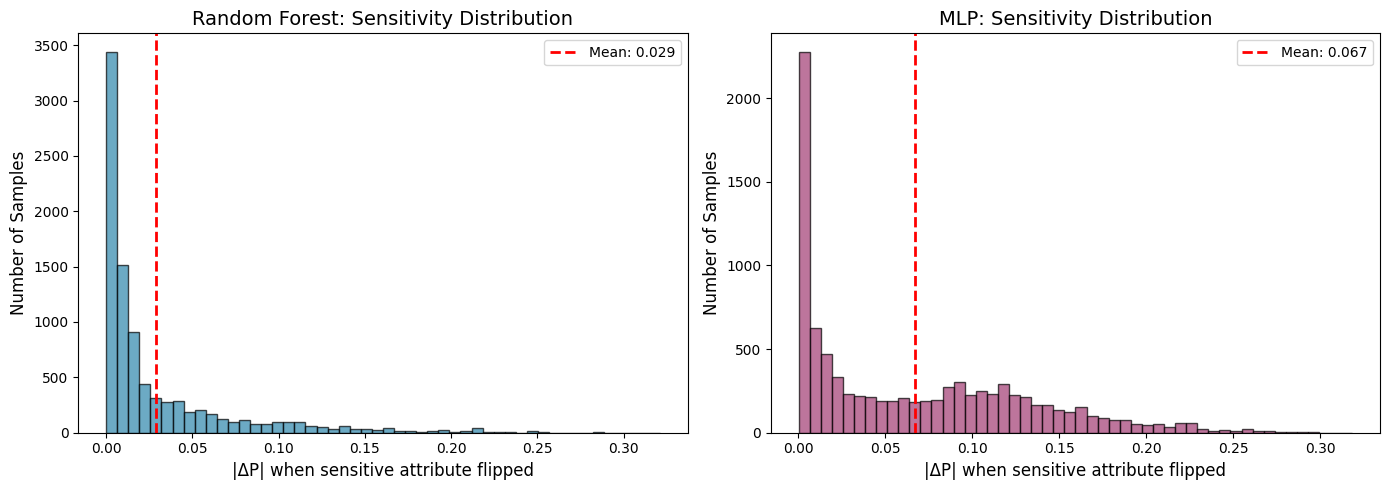

RF:  Mean |ΔP| = 0.0288, Max = 0.3209
MLP: Mean |ΔP| = 0.0668, Max = 0.3186


In [59]:
# ============================================================================
# VISUALIZATION: Probability Change Distribution
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(rf_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0].axvline(x=rf_proba_change.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {rf_proba_change.mean():.3f}')
axes[0].set_xlabel('|ΔP| when sensitive attribute flipped', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Random Forest: Sensitivity Distribution', fontsize=14)
axes[0].legend()

axes[1].hist(mlp_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[1].axvline(x=mlp_proba_change.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mlp_proba_change.mean():.3f}')
axes[1].set_xlabel('|ΔP| when sensitive attribute flipped', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('MLP: Sensitivity Distribution', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/notebook/probability_sensitivity.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/latex/probability_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"RF:  Mean |ΔP| = {rf_proba_change.mean():.4f}, Max = {rf_proba_change.max():.4f}")
print(f"MLP: Mean |ΔP| = {mlp_proba_change.mean():.4f}, Max = {mlp_proba_change.max():.4f}")

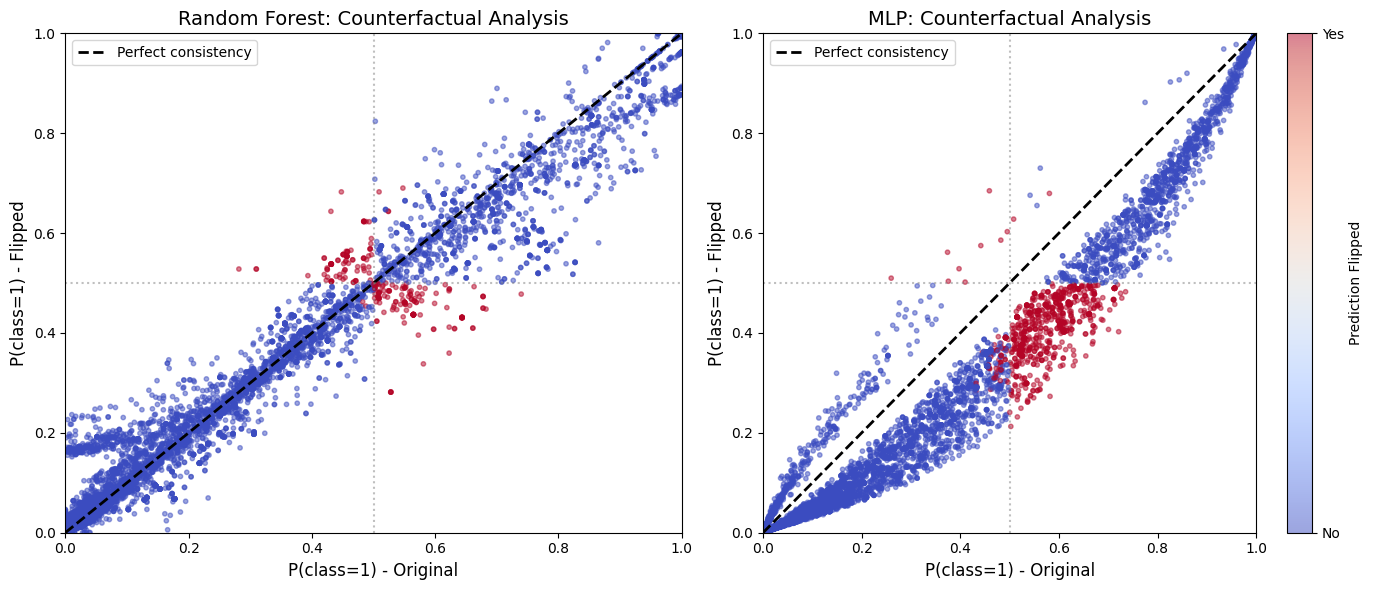

Blue = consistent (fair), Red = prediction flipped (unfair)
Points in upper-left/lower-right quadrants crossed the decision boundary
(For multiclass: showing probability change to max-change target category)


In [60]:
# ============================================================================
# VISUALIZATION: Original vs Flipped Probability Scatter
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

is_multiclass = data.get('is_multiclass', False)

if is_multiclass:
    # For multiclass, use the max-change flip for visualization
    rf_proba_flip_viz = np.array([rf_probas_flipped[rf_max_flip_target[i]][i] for i in range(len(rf_proba_orig))])
    mlp_proba_flip_viz = np.array([mlp_probas_flipped[mlp_max_flip_target[i]][i] for i in range(len(mlp_proba_orig))])
else:
    rf_proba_flip_viz = rf_proba_flip
    mlp_proba_flip_viz = mlp_proba_flip

# RF scatter
scatter1 = axes[0].scatter(rf_proba_orig, rf_proba_flip_viz, 
                           c=rf_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('P(class=1) - Original', fontsize=12)
axes[0].set_ylabel('P(class=1) - Flipped', fontsize=12)
axes[0].set_title('Random Forest: Counterfactual Analysis', fontsize=14)
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# MLP scatter
scatter2 = axes[1].scatter(mlp_proba_orig, mlp_proba_flip_viz,
                           c=mlp_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('P(class=1) - Original', fontsize=12)
axes[1].set_ylabel('P(class=1) - Flipped', fontsize=12)
axes[1].set_title('MLP: Counterfactual Analysis', fontsize=14)
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

cbar = plt.colorbar(scatter2, ax=axes[1])
cbar.set_label('Prediction Flipped', fontsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/notebook/counterfactual_scatter.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/latex/counterfactual_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("Blue = consistent (fair), Red = prediction flipped (unfair)")
print("Points in upper-left/lower-right quadrants crossed the decision boundary")
if is_multiclass:
    print("(For multiclass: showing probability change to max-change target category)")

---

# Approach 2: Models WITHOUT Sensitive Features + SenSeI

In this section, we compare models trained **without sensitive features** (sex, race removed):

**Models compared:**
1. **Random Forest** - trained without sex/race, evaluated on proxy
2. **MLP** - trained without sex/race, evaluated on proxy  
3. **SenSeI** - IBM's individual fairness model with Lipschitz constraint

**Key differences from Approach 1:**
- Sensitive features (sex_Male, race_White) are **removed** from all models
- SenSeI uses these removed features to learn a **fair distance metric**
- Counterfactual consistency is evaluated on **proxy feature** (`relationship_Wife`)

**Why relationship_Wife?**
- `relationship_Wife` is a strong proxy for gender (Wife → Female)
- This tests if models can still discriminate via correlated features
- This is the same evaluation metric IBM uses in their `inFairness` examples


In [42]:
# Import Approach 2 functions
from main import (
    main_approach2,
    run_optimization,
    SENSEI_AVAILABLE,
)

# Check if SenSeI is available
print("=" * 60)
print("APPROACH 2: Setup")
print("=" * 60)
print(f"SenSeI available: {SENSEI_AVAILABLE}")
if not SENSEI_AVAILABLE:
    print("⚠️  Install inFairness for SenSeI: pip install inFairness")
    print("   Will run RF and MLP without SenSeI comparison")


APPROACH 2: Setup
SenSeI available: True


In [64]:
# Approach 2 Configuration
DATASET_NAME_A2 = "adult"
SENSITIVE_FEATURES_TO_REMOVE = ["sex", "race"]  # Features to remove from training
PROXY_FEATURE = "relationship"  # Proxy for counterfactual (uses relationship_Wife)

# Use same time limits as Approach 1
WALLTIME_LIMIT_A2 = 600
N_TRIALS_A2 = 150

# Whether to include SenSeI (set to False to skip if it's slow or unavailable)
INCLUDE_SENSEI = SENSEI_AVAILABLE

print("=" * 60)
print("APPROACH 2 Configuration")
print("=" * 60)
print(f"  Dataset: {DATASET_NAME_A2}")
print(f"  Sensitive features REMOVED: {SENSITIVE_FEATURES_TO_REMOVE}")
print(f"  Proxy feature for counterfactual: {PROXY_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT_A2}s")
print(f"  Max trials per model: {N_TRIALS_A2}")
print(f"  Include SenSeI: {INCLUDE_SENSEI}")


APPROACH 2 Configuration
  Dataset: adult
  Sensitive features REMOVED: ['sex', 'race']
  Proxy feature for counterfactual: relationship
  Time limit per model: 600s
  Max trials per model: 150
  Include SenSeI: True


In [65]:
# Load dataset for Approach 2 (without sensitive features)
data_a2 = load_dataset(
    DATASET_NAME_A2,
    approach=2,
    sensitive_features_to_remove=SENSITIVE_FEATURES_TO_REMOVE,
    proxy_feature=PROXY_FEATURE,
)

print("\n" + "=" * 60)
print("APPROACH 2: Data Summary")
print("=" * 60)
print(f"  X_train shape: {data_a2['X_train'].shape}")
print(f"  y_train distribution: {np.bincount(data_a2['y_train'])}")
print(f"  Proxy column: {data_a2['proxy_col_name']} (index {data_a2['proxy_col_idx']})")
if data_a2['X_protected'] is not None:
    print(f"  X_protected shape: {data_a2['X_protected'].shape}")
    print(f"  Protected features: {data_a2['protected_feature_names']}")


Loading Adult Income from OpenML (ID: 179)...
APPROACH 2: Removing sensitive features from training
  Sensitive features to remove: ['sex', 'race']
  Proxy feature for counterfactual: relationship
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Protected features (for SenSeI): ['sex_Male', 'race_White']
Proxy column for counterfactual: relationship_Wife (index 35)

Final features (56): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 2):
  Samples: 45222, Features: 56
  Positive class ratio: 24.78%

APPROACH 2: Data Summary
  X_train shape: (45222, 56)
  y_train distribution: [34014 11208]
  Proxy column: relationship_Wife (index 35)
  X_protect

In [ ]:
%%time

# Run optimization for Approach 2 models OR load from cache
if LOAD_FROM_CACHE:
    print("Loading Approach 2 results from cache...")
    results_a2 = load_smac_results(DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)
else:
    print("Running SMAC optimization for Approach 2...")
    results_a2 = {}
    
    # Standard models without sensitive features
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()} (Approach 2 - No Sensitive Features)...")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data_a2,
            walltime_limit=WALLTIME_LIMIT_A2 // 2,
            n_trials=N_TRIALS_A2 // 2,
            output_dir="../smac_output",
            approach=2,
        )
        results_a2[model_type] = smac
    
    # SenSeI (if available and requested)
    if INCLUDE_SENSEI:
        print(f"\n{'='*60}")
        print(f"Optimizing SenSeI (Approach 2 - Individual Fairness Training)...")
        print(f"{'='*60}")
        
        try:
            smac_sensei = run_optimization(
                model_type="sensei",
                data=data_a2,
                walltime_limit=WALLTIME_LIMIT_A2 * 2,
                n_trials=N_TRIALS_A2 * 2,
                output_dir="../smac_output",
                approach=2,
            )
            results_a2["sensei"] = smac_sensei
        except Exception as e:
            print(f"⚠️  SenSeI optimization failed: {e}")
            print("   Continuing with RF and MLP only.")
    
    print("\n" + "="*60)
    print("Approach 2 Optimization complete!")
    print(f"Models optimized: {list(results_a2.keys())}")
    print("="*60)
    
    # Save results to cache for future use
    save_smac_results(results_a2, DATASET_NAME_A2, f"{PROXY_FEATURE}_approach2", approach=2)


Optimizing RF (Approach 2 - No Sensitive Features)...

Running SMAC optimization for RF (Approach 2)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:596] Added config 31471b and rejected config 5a799a as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 864316 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:604] Config 7e38f9 is a new incumbent. Total number of incumbents: 5.
[INFO][abstract

In [57]:
# Print Pareto summary for Approach 2
print_pareto_summary(results_a2)




PARETO FRONT SUMMARY

RF Pareto Front (8 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7693, Consistency=0.9838
  Config 2: Accuracy=0.7593, Consistency=0.9953
  Config 3: Accuracy=0.7591, Consistency=0.9960
  Config 4: Accuracy=0.7589, Consistency=0.9966
  Config 5: Accuracy=0.7576, Consistency=0.9977
  Config 6: Accuracy=0.7530, Consistency=0.9986
  Config 7: Accuracy=0.7318, Consistency=1.0000
  Config 8: Accuracy=0.7294, Consistency=1.0000

  Best Accuracy: 0.7693 (Consistency: 0.9838)
  Best Consistency: 1.0000 (Accuracy: 0.7294)

MLP Pareto Front (5 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7786, Consistency=0.9178
  Config 2: Accuracy=0.7780, Consistency=0.9315
  Config 3: Accuracy=0.7749, Consistency=0.9333
  Config 4: Accuracy=0.7739, Consistency=0.9583
  Config 5: Accuracy=0.5000, Consistency=1.0000

  Best Accuracy: 0.7786 (Consistency: 0.9178)
  Best Consistency: 1.0000 (Accuracy:

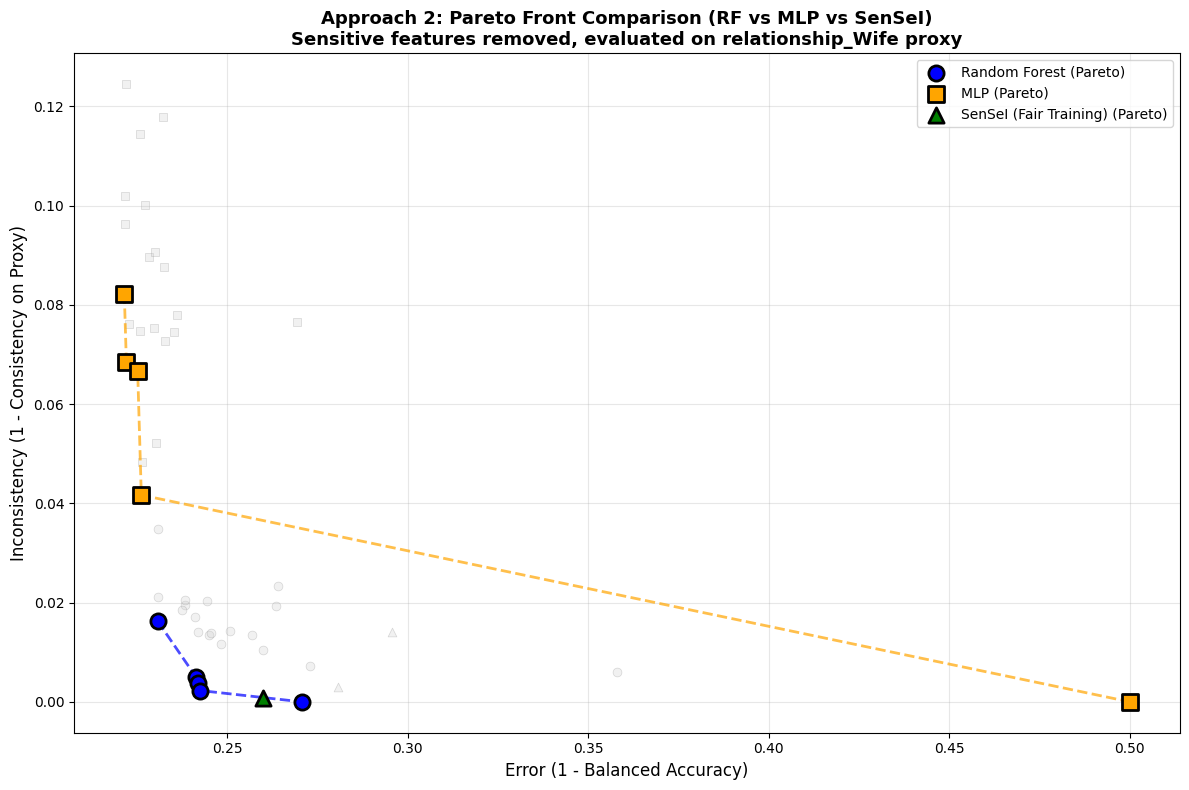

Plot saved to: ../plots/pareto_adult_approach2_with_sensei.png


In [70]:
# If SenSeI was optimized, create a combined Pareto plot including all 3 models
if "sensei" in results_a2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
    markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}
    labels = {'rf': 'Random Forest', 'mlp': 'MLP', 'sensei': 'SenSeI (Fair Training)'}
    
    for model_type, smac in results_a2.items():
        # Get Pareto front
        configs, pareto_costs = get_pareto_front(smac)
        
        # Get all costs
        all_costs = np.array([smac.runhistory.average_cost(c) 
                             for c in smac.runhistory.get_configs()])
        
        # Plot all points (faded)
        ax.scatter(
            all_costs[:, 0], all_costs[:, 1],
            c='lightgray', marker=markers[model_type],
            alpha=0.3, s=40, edgecolors='gray', linewidths=0.5,
            zorder=1
        )
        
        # Plot Pareto front (highlighted)
        ax.scatter(
            pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], marker=markers[model_type],
            s=120, edgecolors='black', linewidths=2,
            label=f'{labels[model_type]} (Pareto)',
            zorder=3
        )
        # Connect Pareto points
        ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
                c=colors[model_type], linestyle='--', linewidth=2, alpha=0.7, zorder=2)
    
    ax.set_xlabel('Error (1 - Balanced Accuracy)', fontsize=12)
    ax.set_ylabel('Inconsistency (1 - Consistency on Proxy)', fontsize=12)
    ax.set_title('Approach 2: Pareto Front Comparison (RF vs MLP vs SenSeI)\n'
                 'Sensitive features removed, evaluated on relationship_Wife proxy',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    sensei_pareto_path = f"{OUTPUT_DIR}/pareto_{DATASET_NAME_A2}_approach2_with_sensei.png"
    plt.savefig(sensei_pareto_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {sensei_pareto_path}")
else:
    print("SenSeI not included in results - skipping combined plot")


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_rf.png

Approach 2 - Random Forest Parallel Coordinate Plot:


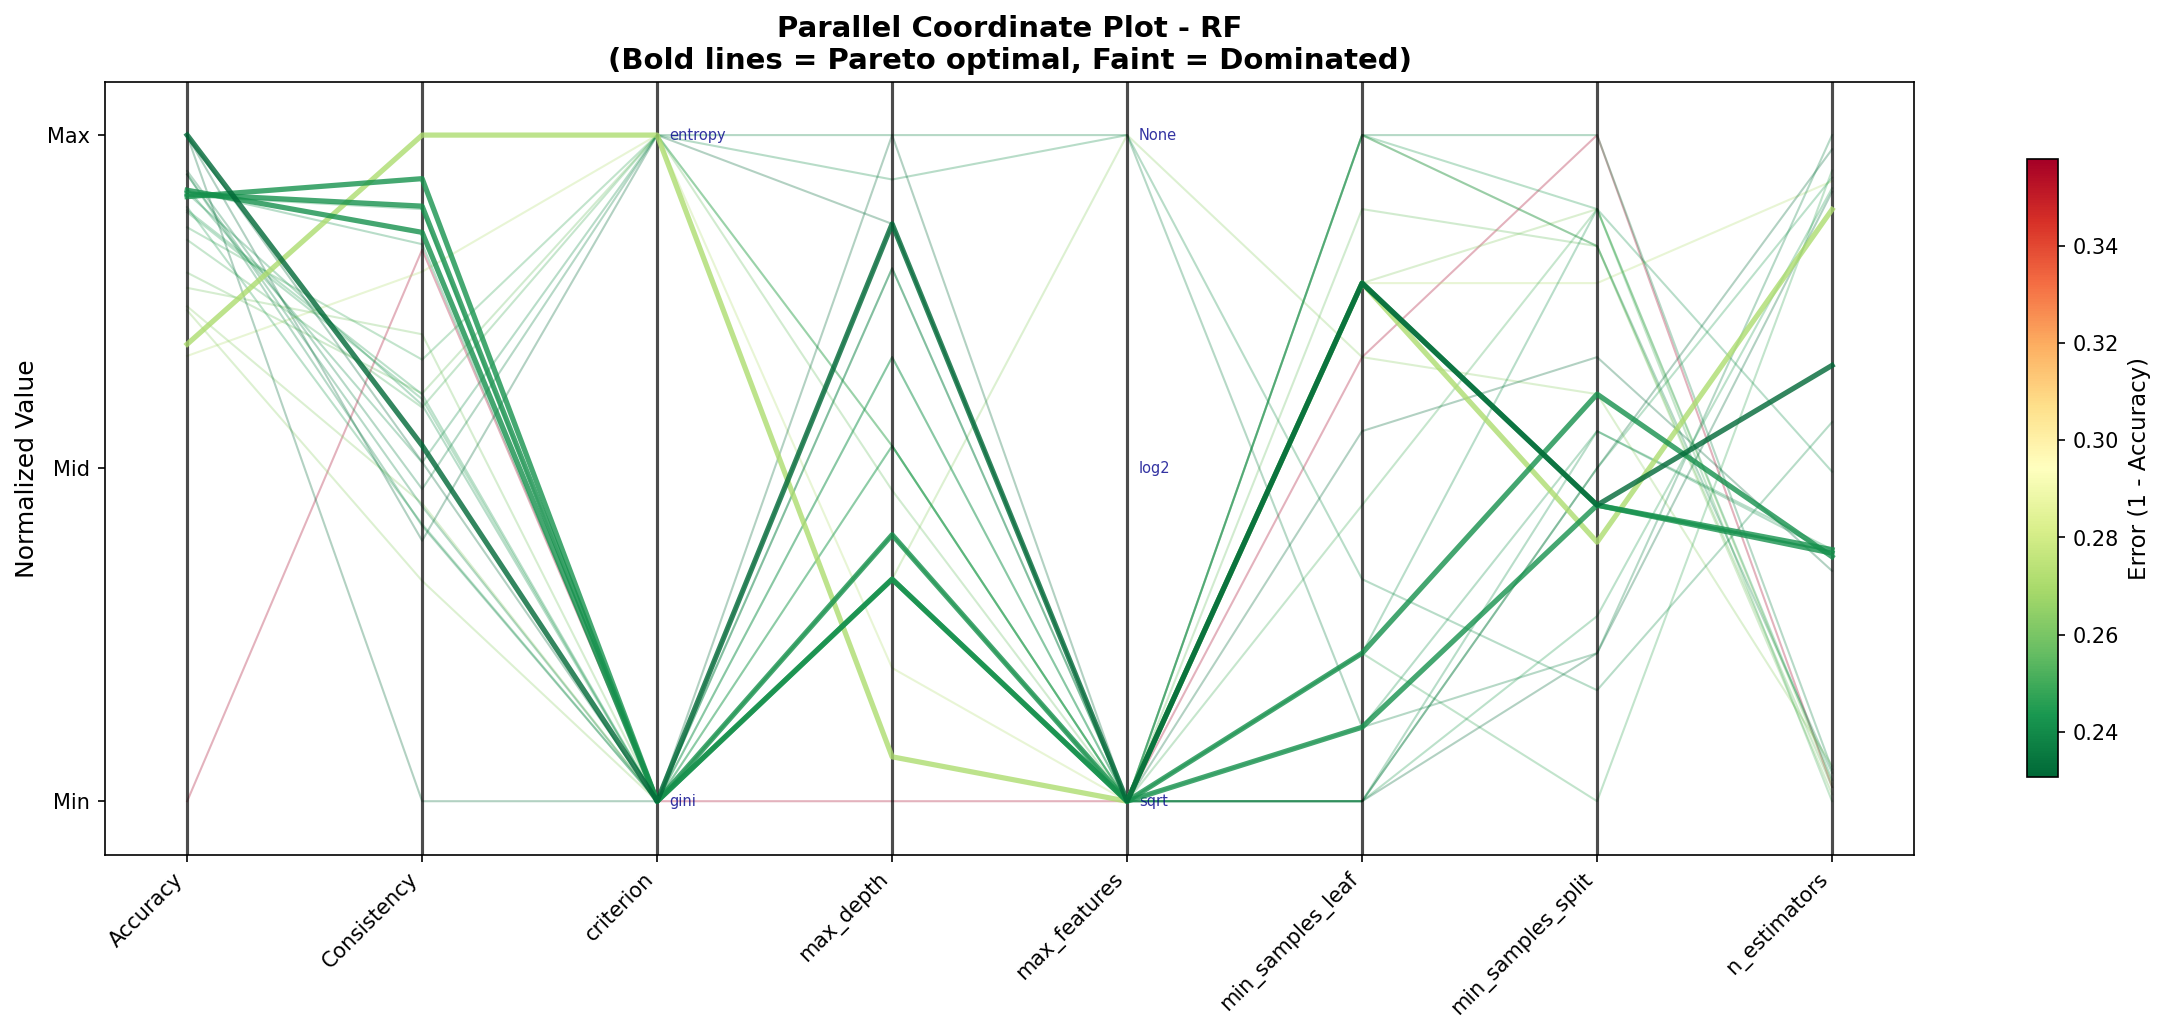

In [71]:
# Approach 2 - Random Forest Parallel Coordinates
rf_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_rf.png"
plot_parallel_coordinates(results_a2['rf'], 'rf', output_path=rf_parallel_path_a2, color_by='error')

print("\nApproach 2 - Random Forest Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_path_a2))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_mlp.png

Approach 2 - MLP Parallel Coordinate Plot:


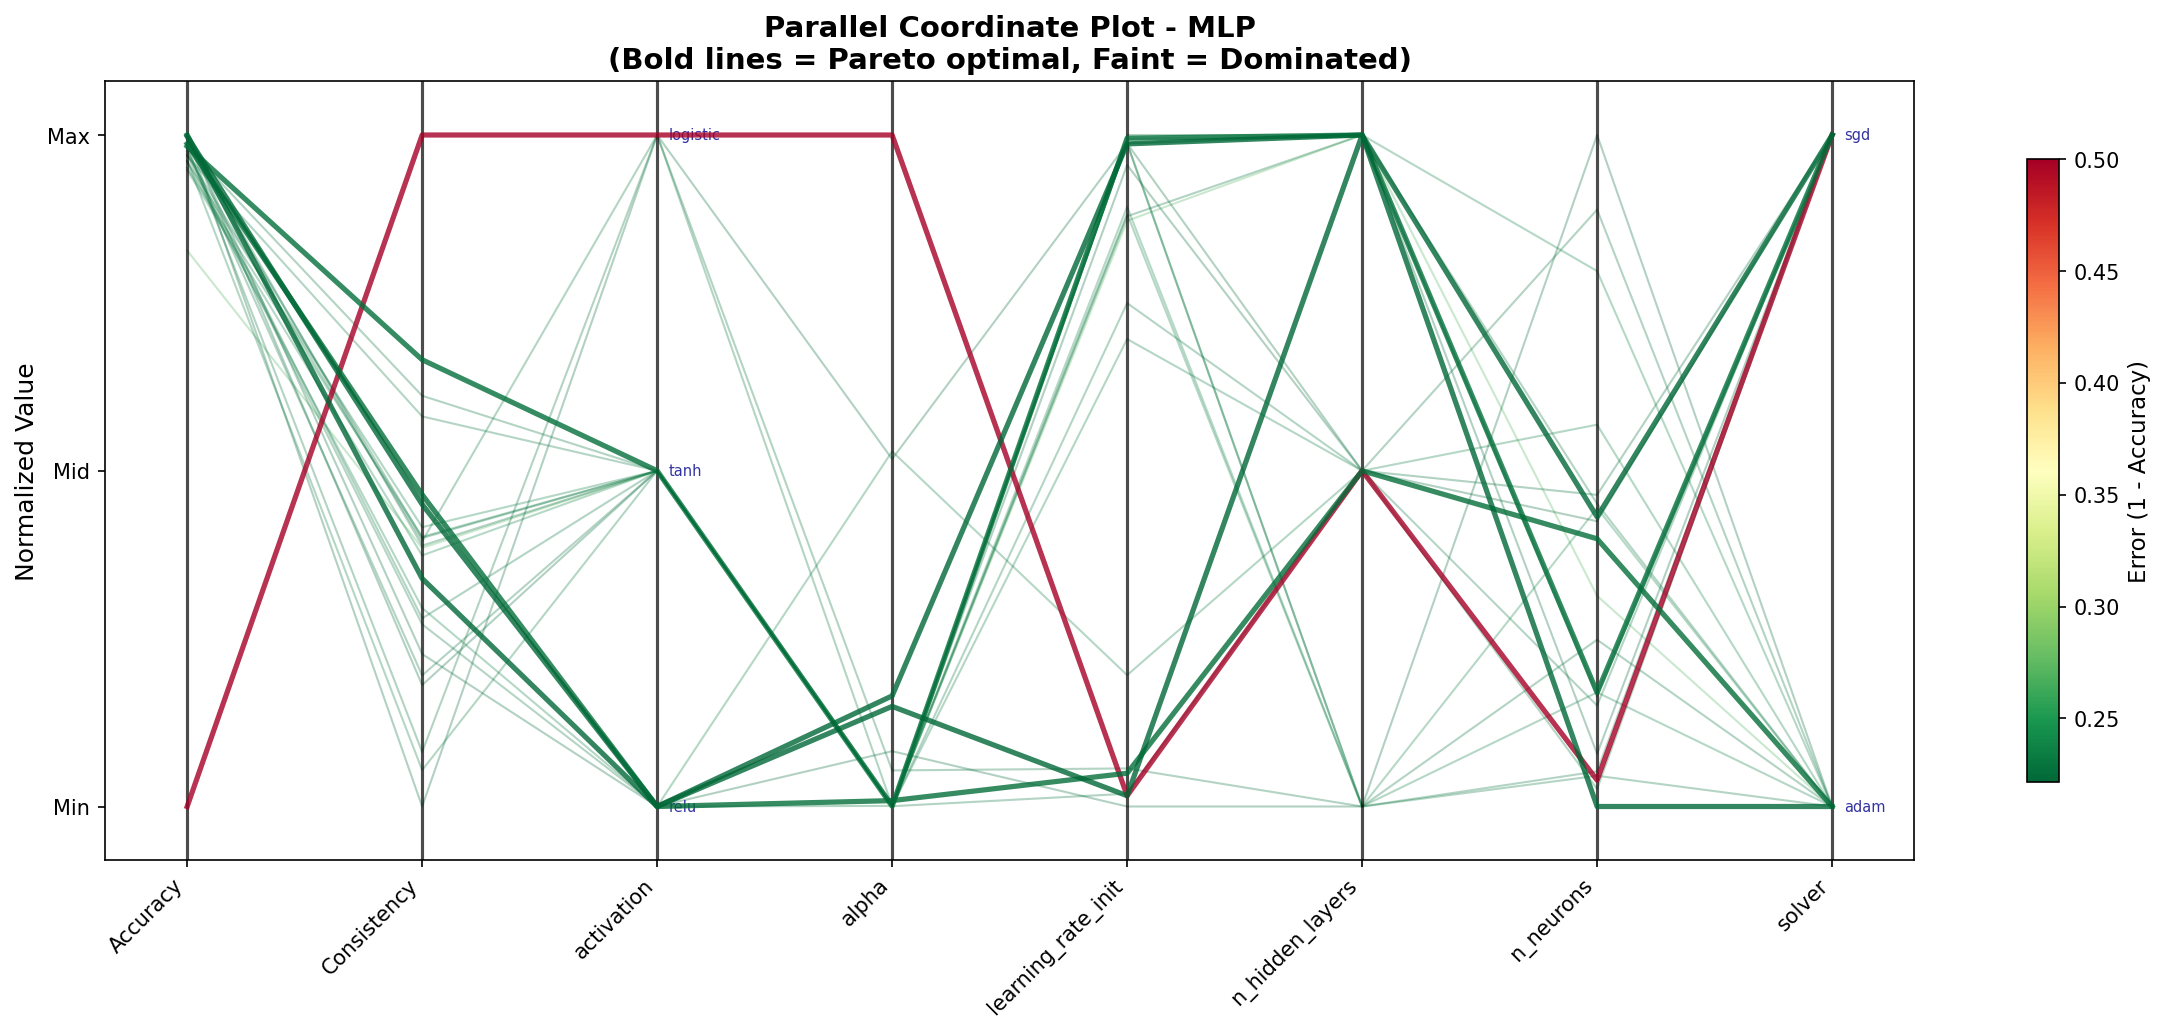

In [72]:
# Approach 2 - MLP Parallel Coordinates
mlp_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_mlp.png"
plot_parallel_coordinates(results_a2['mlp'], 'mlp', output_path=mlp_parallel_path_a2, color_by='error')

print("\nApproach 2 - MLP Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_path_a2))


MDS projection plot saved to: ../plots/mds_projection_adult_approach2_rf.png

Approach 2 - Random Forest MDS Projection:


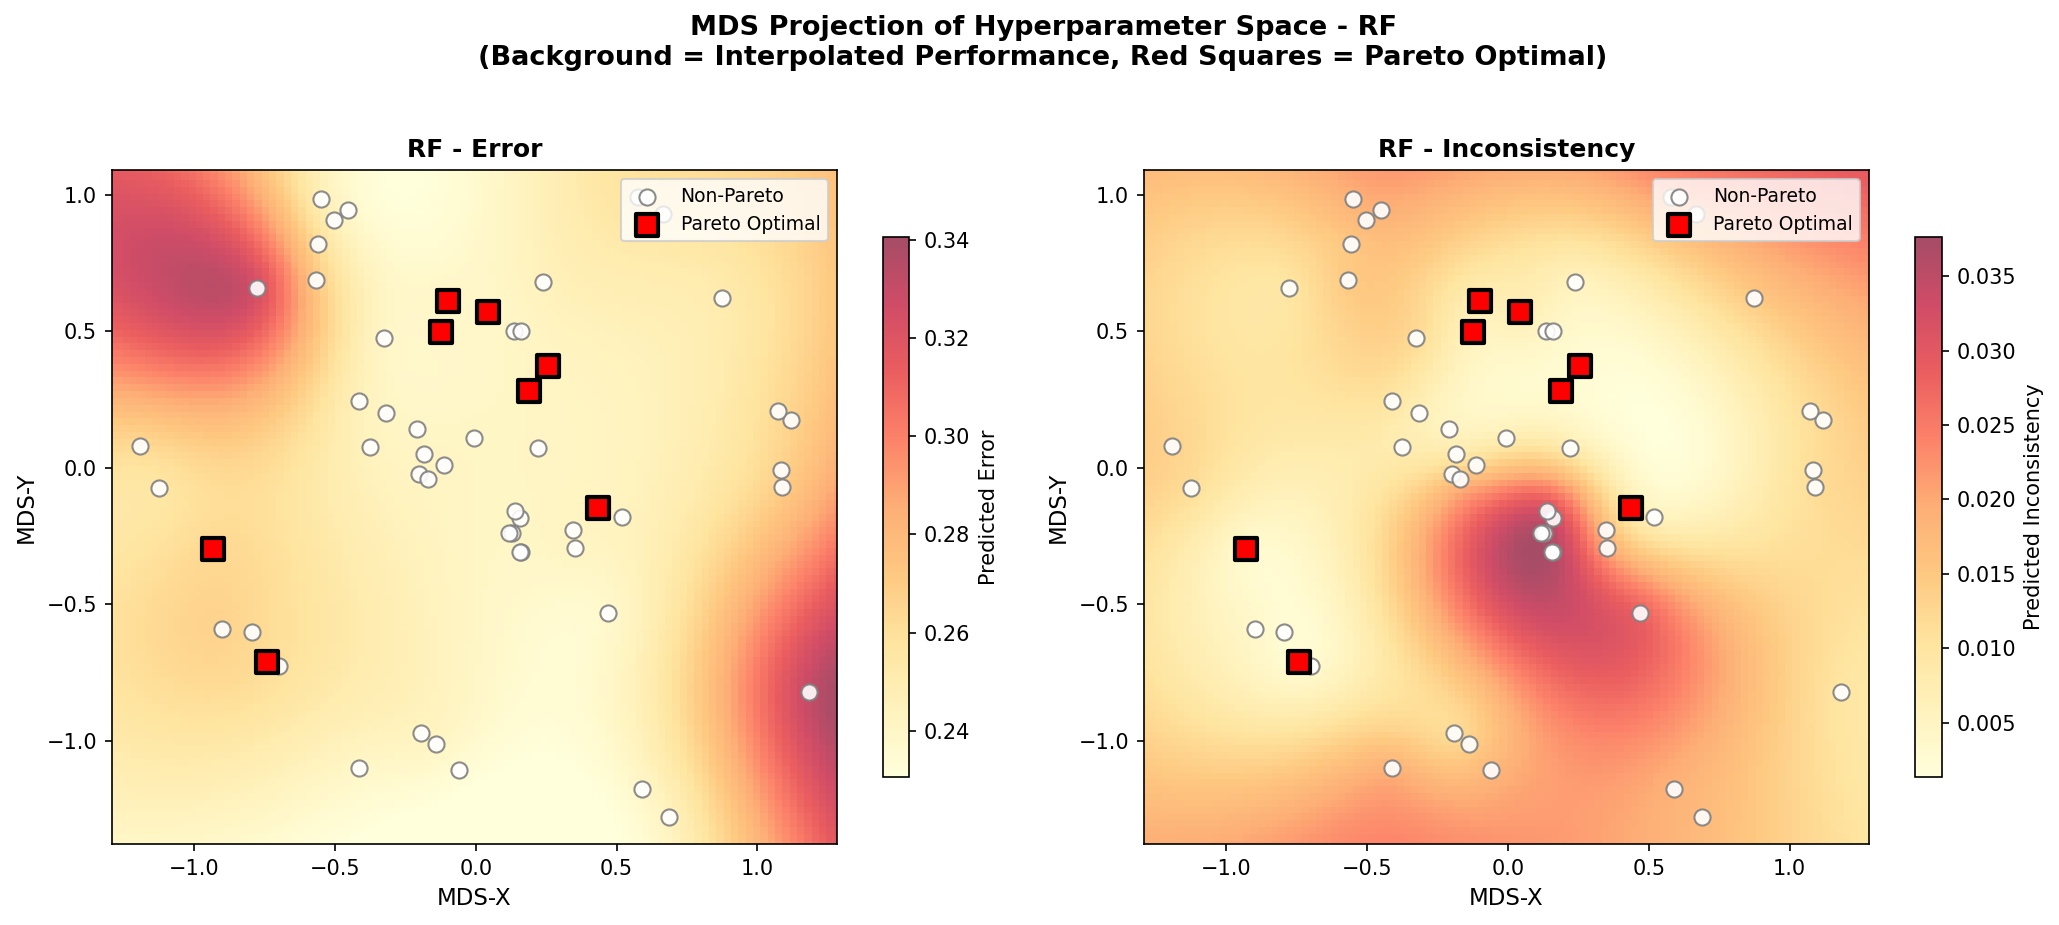

In [56]:
# Approach 2 - Random Forest MDS Projection
rf_mds_path_a2 = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME_A2}_approach2_rf.png"
plot_mds_projection(results_a2['rf'], 'rf', output_path=rf_mds_path_a2)

print("\nApproach 2 - Random Forest MDS Projection:")
display(Image(filename=rf_mds_path_a2))


## Approach 1 vs Approach 2: Comparison Summary

| Aspect | Approach 1 | Approach 2 |
|--------|-----------|-----------|
| **Sensitive features in model** | Yes (sex_Male, race_White) | No (removed) |
| **Counterfactual target** | Flip sex_Male directly | Flip relationship_Wife (proxy) |
| **Models compared** | RF, MLP | RF, MLP, SenSeI |
| **Fairness enforcement** | Post-hoc evaluation only | SenSeI: In-training enforcement |
| **Fair distance metric** | N/A | SenSeI uses LogisticRegSensitiveSubspace |

**Key questions this comparison answers:**
1. Does removing sensitive features improve fairness? (Compare RF/MLP Approach 1 vs Approach 2)
2. Does in-training fairness (SenSeI) outperform post-hoc evaluation? (Compare SenSeI vs RF/MLP)
3. Can models still discriminate via proxy features? (Approach 2 counterfactual results)


In [ ]:
# Compare best configurations from Approach 1 vs Approach 2
print("=" * 80)
print("COMPARISON: Approach 1 vs Approach 2 - Best Configurations")
print("=" * 80)

def get_best_configs(results_dict, approach_name):
    """Extract best accuracy and best fairness configs from results."""
    print(f"\n{approach_name}:")
    print("-" * 60)
    
    for model_type, smac in results_dict.items():
        configs, costs = get_pareto_front(smac)
        
        # Best accuracy
        best_acc_idx = np.argmin(costs[:, 0])
        best_acc = 1 - costs[best_acc_idx, 0]
        best_acc_cons = 1 - costs[best_acc_idx, 1]
        
        # Best consistency
        best_cons_idx = np.argmin(costs[:, 1])
        best_cons = 1 - costs[best_cons_idx, 1]
        best_cons_acc = 1 - costs[best_cons_idx, 0]
        
        print(f"\n  {model_type.upper()}:")
        print(f"    Best Accuracy:    Acc={best_acc:.4f}, Cons={best_acc_cons:.4f}")
        print(f"    Best Consistency: Acc={best_cons_acc:.4f}, Cons={best_cons:.4f}")

# # Approach 1 (with sensitive features, flip sex)
get_best_configs(results, "APPROACH 1 (With Sensitive Features, Flip Sex)")

# Approach 2 (without sensitive features, flip proxy)
get_best_configs(results_a2, "APPROACH 2 (Without Sensitive Features, Flip Proxy)")


COMPARISON: Approach 1 vs Approach 2 - Best Configurations

APPROACH 2 (Without Sensitive Features, Flip Proxy):
------------------------------------------------------------

  RF:
    Best Accuracy:    Acc=0.7693, Cons=0.9838
    Best Consistency: Acc=0.7294, Cons=1.0000

  MLP:
    Best Accuracy:    Acc=0.7786, Cons=0.9178
    Best Consistency: Acc=0.5000, Cons=1.0000

  SENSEI:
    Best Accuracy:    Acc=0.7403, Cons=0.9993
    Best Consistency: Acc=0.7403, Cons=0.9993


AttributeError: 'list' object has no attribute 'items'

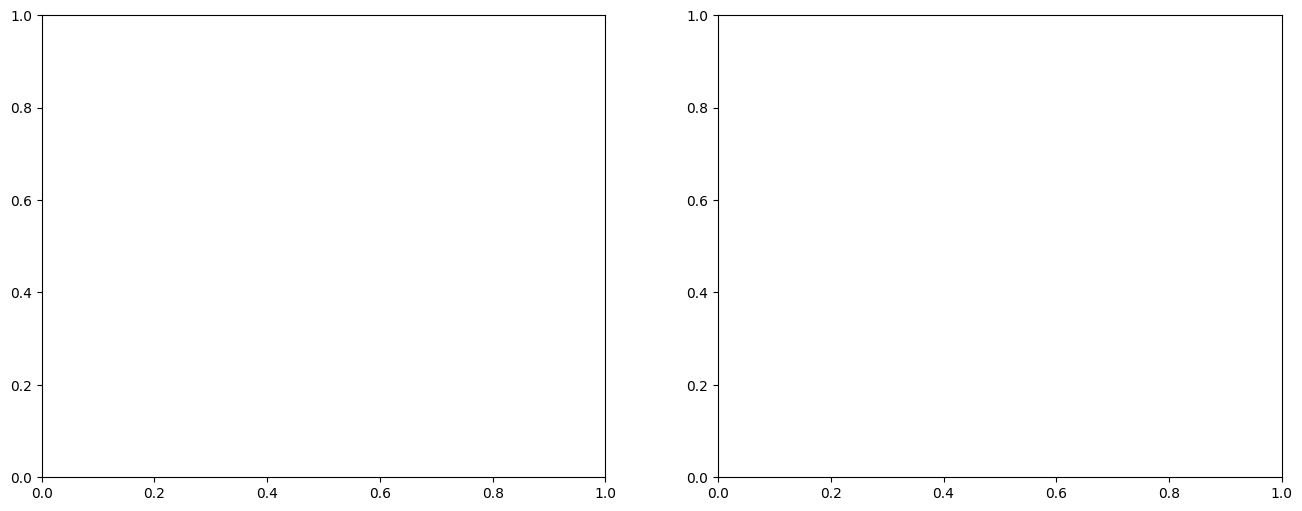

In [76]:
# Visual comparison: Approach 1 vs Approach 2 side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Common settings
colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}

# Plot Approach 1
ax = axes[0]
for model_type, smac in results.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 1: WITH Sensitive Features\n(Flip sex directly)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot Approach 2
ax = axes[1]
for model_type, smac in results_a2.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 2: WITHOUT Sensitive Features\n(Flip proxy: relationship_Wife)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Match axis limits for comparison
all_errors = []
all_incons = []
for res in [results, results_a2]:
    for smac in res.values():
        configs, costs = get_pareto_front(smac)
        all_errors.extend(costs[:, 0])
        all_incons.extend(costs[:, 1])

err_min, err_max = min(all_errors) - 0.02, max(all_errors) + 0.02
inc_min, inc_max = min(all_incons) - 0.02, max(all_incons) + 0.02

for ax in axes:
    ax.set_xlim(err_min, err_max)
    ax.set_ylim(inc_min, inc_max)

plt.suptitle('Comparison: Approach 1 vs Approach 2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comparison_approach1_vs_approach2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: {OUTPUT_DIR}/comparison_approach1_vs_approach2.png")
